# Excercise 2b
Authors: Moro Palma Loris, Vedasri Nakka, Mirko Bristle, Alexandra Kovacs, Michael Brunner


Deadline: April 19, 2021 (end of day) With this exercise you should use your framework to apply an MLP approach to the MNIST dataset.
The goal of this exercise is to train an MLP with one hidden layer and experiment with diﬀerent parameters.

- Reminder: From now on you are free to either implement algorithms on your own or use any kinds of libraries.

### MLP Use the provided training set to train an MLP with one hidden layer. Apply the trained MLP to classify the test set. Perform validation with the following parameters:

• Optimize number of neurons in the hidden layer (typically in the range [10, 100]).

• Optimize learning rate (typically in the range [0.001, 0.1]).

• Optimize number of training iterations. Plot a graph showing the error on the training set and the validation set, respectively, with respect to the training epochs.

• Perform the random initialization several times and choose the best network during validation.

### Expected Output • Access to your GitHub so that we can inspect your code.

• Small report in PDF / README format on the GitHub containing:

– Plot showing the accuracy and loss on the training and the validation set with respect to the training epochs.

– Accuracy with the best parameters found during validation.

TODO how we approach it

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

train_file = pd.read_csv('mnist_train.csv', header=0)
test_file = pd.read_csv('mnist_test.csv', header=0)

width = 28
height = 28
channels = 1


train_y_ = train_file.iloc[:,0].to_numpy()
train_x_ = train_file.iloc[:,1:].to_numpy()

test_y_ = test_file.iloc[:,0].to_numpy()
test_x_ = test_file.iloc[:,1:].to_numpy()

test_images = torch.tensor(test_x_)/255.0
test_labels = torch.tensor(test_y_)

trainfull_images = torch.tensor(train_x_)/255.0
trainfull_labels = torch.tensor(train_y_)

# Pick first 50K for train and rest 9.999K images as validation
train_images = trainfull_images[:50000]
train_labels = trainfull_labels[:50000]

val_images = trainfull_images[50000:]
val_labels = trainfull_labels[50000:]

print("Train images: {},  Valiation images: {}, Test images: {}".\
      format(len(train_labels), len(val_labels), len(test_labels)))



Train images: 50000,  Valiation images: 9999, Test images: 9999


In [32]:
class MLP(nn.Module):
    """ Single hidden layer MLP
    """
    def __init__(self, neurons):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28,neurons) #neurons 
        self.fc2 = nn.Linear(neurons, 10)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [33]:
def predict(net, images_, labels_, loss_fn):
    """ Function to find predictions on given test images.
    """
    
    
    batch_size = 1000
    start = 0
    num_batches = math.ceil(len(images_)/batch_size)
    predictions = []
    loss = []
    
    for i in range(num_batches):
        batch_images = images_[start:start+batch_size].view(-1, width*height*channels)
        batch_labels = labels_[start:start+batch_size]
        output = net(batch_images)
        loss_ = loss_fn(output, batch_labels)
        predictions.extend(torch.argmax(output,1).numpy()) 
        loss.append(loss_.item())
        start +=batch_size
    
    return predictions, np.mean(loss)
    
def accuracy(pred_labels, true_labels):
    return np.mean(true_labels.numpy() == pred_labels)

In [55]:
def training(neurons, learning_rate, epochs, batch_size, num_batches):
    """ Function to train the MLP model.
    """
    correct = 0
    total = 0
    NO_EPOCHS = epochs
    enum_no_epochs = []
    acc_val = []
    acc_train = []
    acc_test = []
    loss_val = []
    loss_train = []
    loss_test = []
    

    # Initializes the MLP  with random Weights
    net = MLP(neurons)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) #learning rate 

    for epoch in range(NO_EPOCHS):  
        start = 0
        for i in (range(batch_size)):
            optimizer.zero_grad()
            batch_images = train_images[start:start+batch_size].view(-1, width*height*channels)
            batch_labels = train_labels[start:start+batch_size]
            output = net(batch_images)
            loss = loss_fn(output, batch_labels)
            loss.backward()
            optimizer.step()
            start += batch_size


        predictions_train, loss_train_ = predict(net, train_images, train_labels, loss_fn)
        accuracy_train = accuracy(predictions_train, train_labels)
        acc_train.append(100*accuracy_train)
        loss_train.append(loss_train_)

        predictions_val, loss_val_ = predict(net, val_images, val_labels, loss_fn)
        accuracy_val = accuracy(predictions_val, val_labels)
        acc_val.append(100*accuracy_val)
        loss_val.append(loss_val_)


        if epoch%10==0:
            print("Epoch: {:4d}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%"\
              .format(epoch, loss_train_, loss_val_,100*accuracy_train, 100*accuracy_val))


    # Evaluate testimages at end of each epoch, although, they are not used for model selection          
    predictions_test, loss_test_ = predict(net, test_images, test_labels, loss_fn)
    accuracy_test = accuracy(predictions_test, test_labels)
    print("\nFinal Test accuracy for Network with hidden layer of {} neurons and LR: {:.4f} is {:.2f}%\n\n"\
          .format(neurons, learning_rate, accuracy_test*100))
     


    plt.title('CE Loss plot during training stage for lr: {:.4f} and neurons: {}'.format(learning_rate, neurons))
    plt.plot( np.arange(NO_EPOCHS), loss_train, color = "m", linestyle = "--")
    plt.plot( np.arange(NO_EPOCHS), loss_val, color = "c", linestyle = "--")
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.title('Error rate plot during training stage for lr: {:.4f} and neurons: {}'.format(learning_rate, neurons))
    plt.plot( np.arange(NO_EPOCHS), 100-np.array(acc_train), color = "m", linestyle = "--")
    plt.plot( np.arange(NO_EPOCHS), 100-np.array(acc_val), color = "c", linestyle = "--")
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.show()    
    return (accuracy_val, accuracy_test, net, 
            (loss_train, loss_val, 100-np.array(acc_train),100-np.array(acc_val)))
    


----------------------------------------------------------------------------------------
Training Setting as below: 
Num of runs: 5
Batch Size: 1000
No of epochs: 100
No of Batches per epoch: 50
----------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0010 and Hidden layer size: 10

Epoch:    0, Train Loss: 1.4702, Val Loss: 1.4415, Train Accuracy: 64.58%, Validation Accuracy: 67.20%
Epoch:   10, Train Loss: 0.2999, Val Loss: 0.2903, Train Accuracy: 90.91%, Validation Accuracy: 91.46%
Epoch:   20, Train Loss: 0.2474, Val Loss: 0.2587, Train Accuracy: 92.42%, Validation Accuracy: 92.46%
Epoch:   30, Train Loss: 0.2328, Val Loss: 0.2576, Train Accuracy: 92.79%, Validation Accuracy: 92.37%
Epoch:   40, Train Loss: 0.2154, Val Loss: 0.2518, Train Accuracy: 93.30%, Validation Accuracy: 92.65%
Epoch:   50, Train Loss: 0.1998, Val Loss: 0

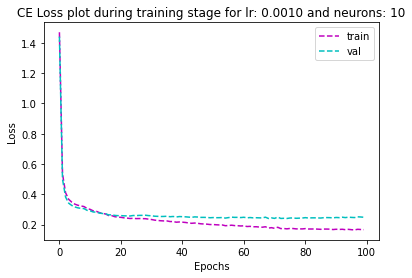

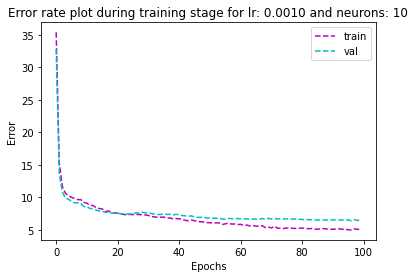

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0010 and Hidden layer size: 10

Epoch:    0, Train Loss: 1.5425, Val Loss: 1.5054, Train Accuracy: 61.17%, Validation Accuracy: 64.27%
Epoch:   10, Train Loss: 0.2786, Val Loss: 0.2717, Train Accuracy: 92.04%, Validation Accuracy: 92.49%
Epoch:   20, Train Loss: 0.2501, Val Loss: 0.2584, Train Accuracy: 92.80%, Validation Accuracy: 92.98%
Epoch:   30, Train Loss: 0.2248, Val Loss: 0.2452, Train Accuracy: 93.61%, Validation Accuracy: 93.47%
Epoch:   40, Train Loss: 0.2093, Val Loss: 0.2394, Train Accuracy: 94.11%, Validation Accuracy: 93.68%
Epoch:   50, Train Loss: 0.2113, Val Loss: 0.2494, Train Accuracy: 93.95%, Validation Accuracy: 93.12%
Epoch:   60, Train Loss: 0.2066, Val Loss: 0.2513, Train Accuracy: 94.07%, Validation Accuracy: 93.08%
Epoch:   70, Train Loss: 0.2119, Val Loss: 0.2626, Train Accuracy: 93.76%, Validation Accuracy: 92.85%
Epoch:   80, Train Lo

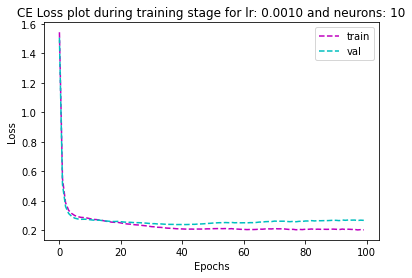

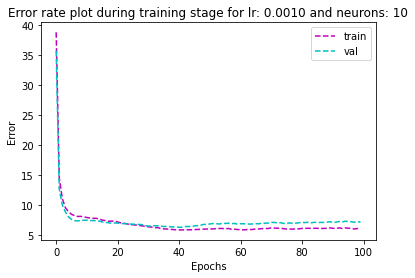

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0010 and Hidden layer size: 10

Epoch:    0, Train Loss: 1.2085, Val Loss: 1.1814, Train Accuracy: 74.08%, Validation Accuracy: 76.39%
Epoch:   10, Train Loss: 0.2581, Val Loss: 0.2548, Train Accuracy: 92.48%, Validation Accuracy: 92.81%
Epoch:   20, Train Loss: 0.2315, Val Loss: 0.2420, Train Accuracy: 93.28%, Validation Accuracy: 92.92%
Epoch:   30, Train Loss: 0.2138, Val Loss: 0.2358, Train Accuracy: 93.67%, Validation Accuracy: 93.34%
Epoch:   40, Train Loss: 0.2081, Val Loss: 0.2424, Train Accuracy: 93.68%, Validation Accuracy: 93.25%
Epoch:   50, Train Loss: 0.1987, Val Loss: 0.2407, Train Accuracy: 93.89%, Validation Accuracy: 93.19%
Epoch:   60, Train Loss: 0.1909, Val Loss: 0.2386, Train Accuracy: 94.12%, Validation Accuracy: 93.27%
Epoch:   70, Train Loss: 0.1852, Val Loss: 0.2391, Train Accuracy: 94.30%, Validation Accuracy: 93.17%
Epoch:   80, Train Lo

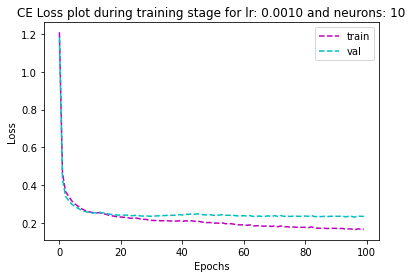

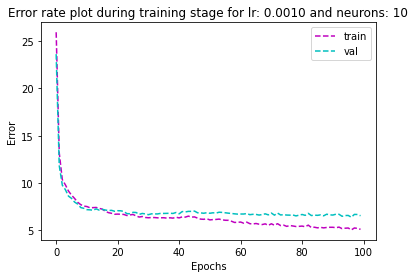

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0010 and Hidden layer size: 10

Epoch:    0, Train Loss: 1.3469, Val Loss: 1.3107, Train Accuracy: 60.70%, Validation Accuracy: 63.25%
Epoch:   10, Train Loss: 0.2701, Val Loss: 0.2671, Train Accuracy: 92.18%, Validation Accuracy: 92.52%
Epoch:   20, Train Loss: 0.2388, Val Loss: 0.2558, Train Accuracy: 93.03%, Validation Accuracy: 92.56%
Epoch:   30, Train Loss: 0.2272, Val Loss: 0.2588, Train Accuracy: 93.30%, Validation Accuracy: 92.70%
Epoch:   40, Train Loss: 0.2202, Val Loss: 0.2613, Train Accuracy: 93.46%, Validation Accuracy: 92.79%
Epoch:   50, Train Loss: 0.2165, Val Loss: 0.2650, Train Accuracy: 93.52%, Validation Accuracy: 92.86%
Epoch:   60, Train Loss: 0.2177, Val Loss: 0.2726, Train Accuracy: 93.42%, Validation Accuracy: 92.73%
Epoch:   70, Train Loss: 0.2157, Val Loss: 0.2769, Train Accuracy: 93.46%, Validation Accuracy: 92.60%
Epoch:   80, Train Lo

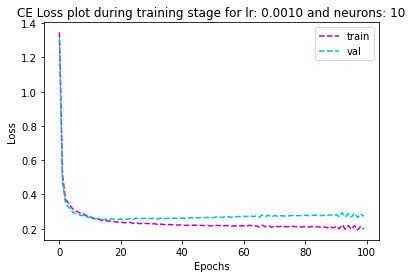

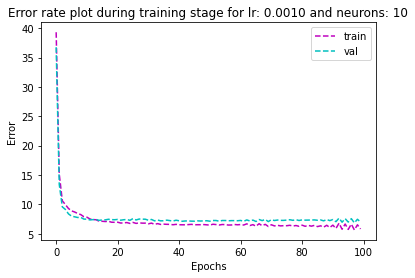

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0010 and Hidden layer size: 10

Epoch:    0, Train Loss: 1.3312, Val Loss: 1.3056, Train Accuracy: 70.24%, Validation Accuracy: 71.71%
Epoch:   10, Train Loss: 0.2912, Val Loss: 0.2917, Train Accuracy: 91.34%, Validation Accuracy: 91.61%
Epoch:   20, Train Loss: 0.2651, Val Loss: 0.2770, Train Accuracy: 92.02%, Validation Accuracy: 92.03%
Epoch:   30, Train Loss: 0.2509, Val Loss: 0.2684, Train Accuracy: 92.30%, Validation Accuracy: 92.00%
Epoch:   40, Train Loss: 0.2394, Val Loss: 0.2654, Train Accuracy: 92.66%, Validation Accuracy: 92.24%
Epoch:   50, Train Loss: 0.2341, Val Loss: 0.2676, Train Accuracy: 92.83%, Validation Accuracy: 92.25%
Epoch:   60, Train Loss: 0.2286, Val Loss: 0.2678, Train Accuracy: 93.02%, Validation Accuracy: 92.25%
Epoch:   70, Train Loss: 0.2232, Val Loss: 0.2673, Train Accuracy: 93.20%, Validation Accuracy: 92.39%
Epoch:   80, Train Lo

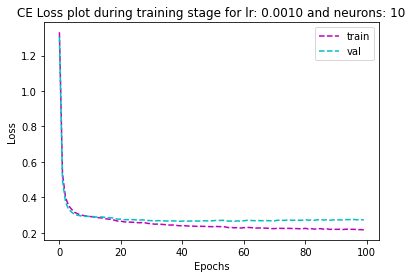

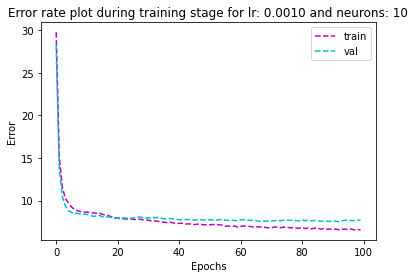

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0010 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.7021, Val Loss: 0.6548, Train Accuracy: 83.35%, Validation Accuracy: 85.17%
Epoch:   10, Train Loss: 0.1281, Val Loss: 0.1537, Train Accuracy: 96.00%, Validation Accuracy: 95.70%
Epoch:   20, Train Loss: 0.1426, Val Loss: 0.2187, Train Accuracy: 95.18%, Validation Accuracy: 94.07%
Epoch:   30, Train Loss: 0.0818, Val Loss: 0.1766, Train Accuracy: 97.15%, Validation Accuracy: 95.55%
Epoch:   40, Train Loss: 0.0849, Val Loss: 0.1925, Train Accuracy: 97.13%, Validation Accuracy: 95.47%
Epoch:   50, Train Loss: 0.0978, Val Loss: 0.2625, Train Accuracy: 97.00%, Validation Accuracy: 95.18%
Epoch:   60, Train Loss: 0.0766, Val Loss: 0.2445, Train Accuracy: 97.65%, Validation Accuracy: 95.54%
Epoch:   70, Train Loss: 0.0365, Val Loss: 0.2132, Train Accuracy: 98.83%, Validation Accuracy: 96.27%
Epoch:   80, Train Lo

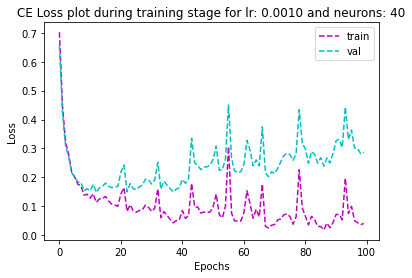

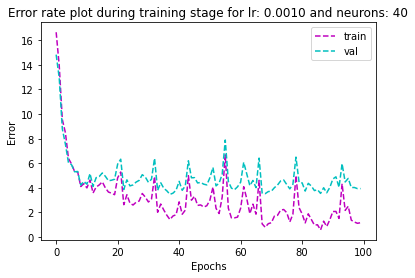

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0010 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.6910, Val Loss: 0.6473, Train Accuracy: 84.42%, Validation Accuracy: 86.15%
Epoch:   10, Train Loss: 0.1496, Val Loss: 0.1797, Train Accuracy: 95.17%, Validation Accuracy: 94.53%
Epoch:   20, Train Loss: 0.1101, Val Loss: 0.1729, Train Accuracy: 96.46%, Validation Accuracy: 95.39%
Epoch:   30, Train Loss: 0.1018, Val Loss: 0.2088, Train Accuracy: 96.58%, Validation Accuracy: 94.80%
Epoch:   40, Train Loss: 0.1776, Val Loss: 0.3156, Train Accuracy: 94.56%, Validation Accuracy: 92.90%
Epoch:   50, Train Loss: 0.0862, Val Loss: 0.2581, Train Accuracy: 97.21%, Validation Accuracy: 94.76%
Epoch:   60, Train Loss: 0.0347, Val Loss: 0.2244, Train Accuracy: 98.81%, Validation Accuracy: 95.98%
Epoch:   70, Train Loss: 0.0380, Val Loss: 0.2546, Train Accuracy: 98.70%, Validation Accuracy: 95.88%
Epoch:   80, Train Lo

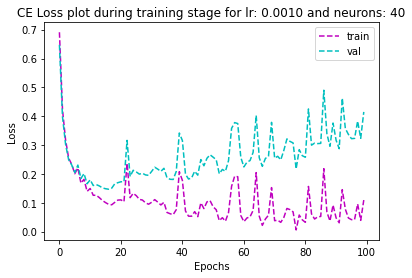

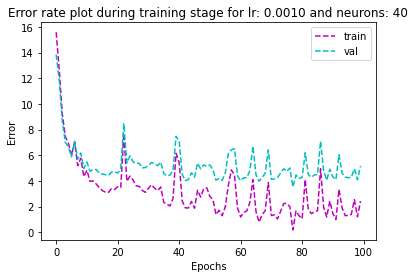

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0010 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.6657, Val Loss: 0.6207, Train Accuracy: 84.20%, Validation Accuracy: 86.23%
Epoch:   10, Train Loss: 0.1358, Val Loss: 0.1623, Train Accuracy: 95.74%, Validation Accuracy: 94.94%
Epoch:   20, Train Loss: 0.0807, Val Loss: 0.1432, Train Accuracy: 97.35%, Validation Accuracy: 95.99%
Epoch:   30, Train Loss: 0.1450, Val Loss: 0.2327, Train Accuracy: 95.30%, Validation Accuracy: 93.95%
Epoch:   40, Train Loss: 0.0928, Val Loss: 0.2192, Train Accuracy: 96.97%, Validation Accuracy: 95.37%
Epoch:   50, Train Loss: 0.0939, Val Loss: 0.2262, Train Accuracy: 97.10%, Validation Accuracy: 95.47%
Epoch:   60, Train Loss: 0.0915, Val Loss: 0.2512, Train Accuracy: 97.22%, Validation Accuracy: 95.48%
Epoch:   70, Train Loss: 0.1113, Val Loss: 0.2897, Train Accuracy: 96.85%, Validation Accuracy: 95.34%
Epoch:   80, Train Lo

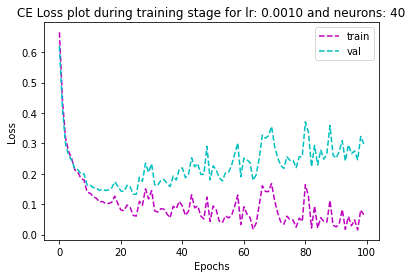

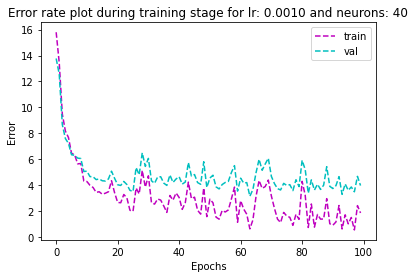

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0010 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.6847, Val Loss: 0.6416, Train Accuracy: 84.65%, Validation Accuracy: 86.43%
Epoch:   10, Train Loss: 0.1325, Val Loss: 0.1643, Train Accuracy: 95.84%, Validation Accuracy: 95.19%
Epoch:   20, Train Loss: 0.0948, Val Loss: 0.1578, Train Accuracy: 97.01%, Validation Accuracy: 95.66%
Epoch:   30, Train Loss: 0.0822, Val Loss: 0.1681, Train Accuracy: 97.28%, Validation Accuracy: 95.75%
Epoch:   40, Train Loss: 0.0839, Val Loss: 0.2205, Train Accuracy: 97.24%, Validation Accuracy: 95.27%
Epoch:   50, Train Loss: 0.1194, Val Loss: 0.2659, Train Accuracy: 96.63%, Validation Accuracy: 94.98%
Epoch:   60, Train Loss: 0.0178, Val Loss: 0.1742, Train Accuracy: 99.40%, Validation Accuracy: 96.67%
Epoch:   70, Train Loss: 0.0569, Val Loss: 0.2344, Train Accuracy: 98.15%, Validation Accuracy: 95.83%
Epoch:   80, Train Lo

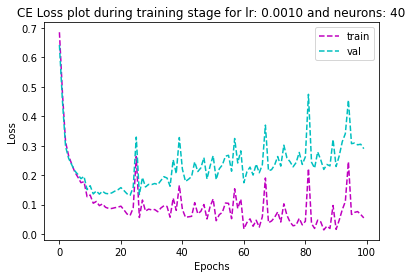

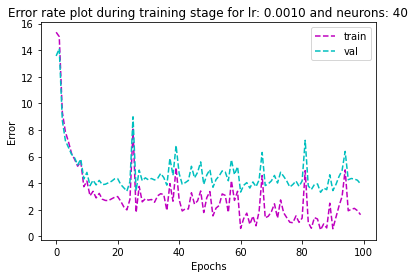

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0010 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.7575, Val Loss: 0.7145, Train Accuracy: 82.71%, Validation Accuracy: 84.60%
Epoch:   10, Train Loss: 0.1520, Val Loss: 0.1823, Train Accuracy: 95.21%, Validation Accuracy: 94.57%
Epoch:   20, Train Loss: 0.1048, Val Loss: 0.1683, Train Accuracy: 96.46%, Validation Accuracy: 95.00%
Epoch:   30, Train Loss: 0.0608, Val Loss: 0.1476, Train Accuracy: 97.95%, Validation Accuracy: 95.88%
Epoch:   40, Train Loss: 0.0594, Val Loss: 0.1676, Train Accuracy: 97.92%, Validation Accuracy: 95.80%
Epoch:   50, Train Loss: 0.0666, Val Loss: 0.2067, Train Accuracy: 97.68%, Validation Accuracy: 95.37%
Epoch:   60, Train Loss: 0.0504, Val Loss: 0.2158, Train Accuracy: 98.34%, Validation Accuracy: 95.55%
Epoch:   70, Train Loss: 0.0389, Val Loss: 0.2552, Train Accuracy: 98.59%, Validation Accuracy: 95.39%
Epoch:   80, Train Lo

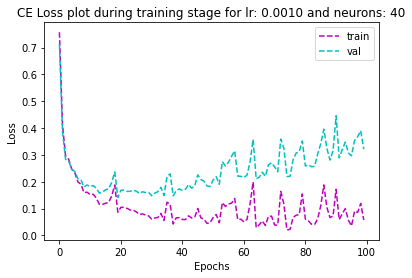

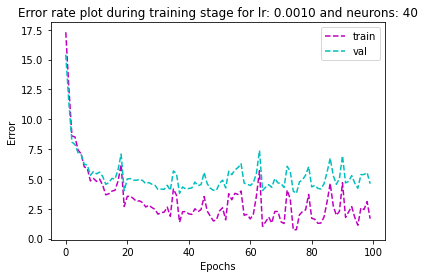

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0010 and Hidden layer size: 70

Epoch:    0, Train Loss: 0.5378, Val Loss: 0.4922, Train Accuracy: 86.29%, Validation Accuracy: 87.82%
Epoch:   10, Train Loss: 0.1123, Val Loss: 0.1482, Train Accuracy: 96.31%, Validation Accuracy: 95.56%
Epoch:   20, Train Loss: 0.1366, Val Loss: 0.2351, Train Accuracy: 95.65%, Validation Accuracy: 94.18%
Epoch:   30, Train Loss: 0.0407, Val Loss: 0.1564, Train Accuracy: 98.52%, Validation Accuracy: 96.24%
Epoch:   40, Train Loss: 0.0647, Val Loss: 0.2100, Train Accuracy: 97.80%, Validation Accuracy: 96.09%
Epoch:   50, Train Loss: 0.0221, Val Loss: 0.1813, Train Accuracy: 99.28%, Validation Accuracy: 96.93%
Epoch:   60, Train Loss: 0.0297, Val Loss: 0.2107, Train Accuracy: 99.04%, Validation Accuracy: 96.77%
Epoch:   70, Train Loss: 0.1217, Val Loss: 0.3383, Train Accuracy: 97.53%, Validation Accuracy: 95.15%
Epoch:   80, Train Lo

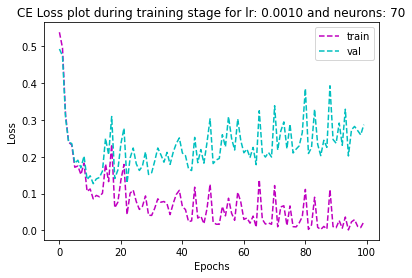

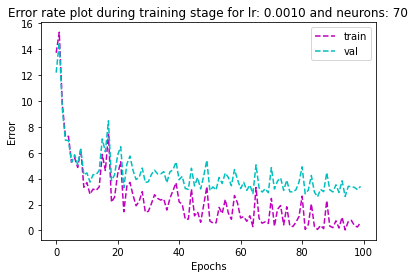

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0010 and Hidden layer size: 70

Epoch:    0, Train Loss: 0.5344, Val Loss: 0.4884, Train Accuracy: 86.07%, Validation Accuracy: 87.68%
Epoch:   10, Train Loss: 0.1619, Val Loss: 0.1998, Train Accuracy: 94.51%, Validation Accuracy: 94.03%
Epoch:   20, Train Loss: 0.0749, Val Loss: 0.1519, Train Accuracy: 97.58%, Validation Accuracy: 95.95%
Epoch:   30, Train Loss: 0.0316, Val Loss: 0.1449, Train Accuracy: 98.93%, Validation Accuracy: 96.72%
Epoch:   40, Train Loss: 0.0832, Val Loss: 0.2169, Train Accuracy: 97.41%, Validation Accuracy: 95.50%
Epoch:   50, Train Loss: 0.0222, Val Loss: 0.1937, Train Accuracy: 99.21%, Validation Accuracy: 96.92%
Epoch:   60, Train Loss: 0.0342, Val Loss: 0.2552, Train Accuracy: 98.95%, Validation Accuracy: 96.13%
Epoch:   70, Train Loss: 0.0422, Val Loss: 0.2571, Train Accuracy: 98.76%, Validation Accuracy: 96.27%
Epoch:   80, Train Lo

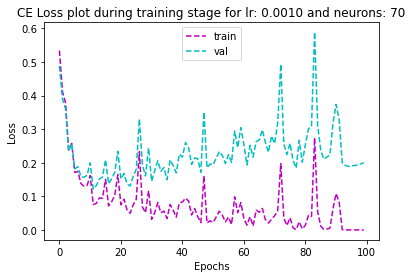

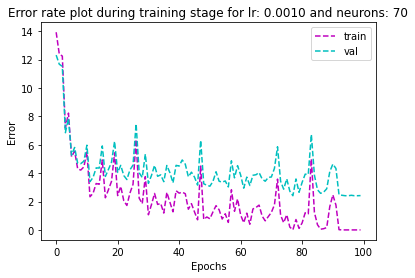

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0010 and Hidden layer size: 70

Epoch:    0, Train Loss: 0.5492, Val Loss: 0.5063, Train Accuracy: 85.84%, Validation Accuracy: 87.25%
Epoch:   10, Train Loss: 0.1075, Val Loss: 0.1469, Train Accuracy: 96.55%, Validation Accuracy: 95.71%
Epoch:   20, Train Loss: 0.0932, Val Loss: 0.1691, Train Accuracy: 96.78%, Validation Accuracy: 95.29%
Epoch:   30, Train Loss: 0.0325, Val Loss: 0.1405, Train Accuracy: 98.88%, Validation Accuracy: 96.73%
Epoch:   40, Train Loss: 0.0199, Val Loss: 0.1427, Train Accuracy: 99.34%, Validation Accuracy: 97.02%
Epoch:   50, Train Loss: 0.2668, Val Loss: 0.4505, Train Accuracy: 94.10%, Validation Accuracy: 92.64%
Epoch:   60, Train Loss: 0.0667, Val Loss: 0.2636, Train Accuracy: 97.95%, Validation Accuracy: 95.86%
Epoch:   70, Train Loss: 0.0640, Val Loss: 0.3042, Train Accuracy: 98.20%, Validation Accuracy: 95.97%
Epoch:   80, Train Lo

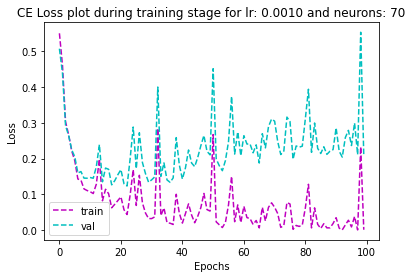

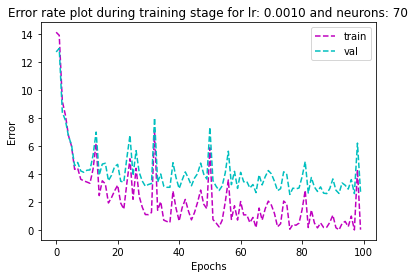

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0010 and Hidden layer size: 70

Epoch:    0, Train Loss: 0.5325, Val Loss: 0.4903, Train Accuracy: 86.13%, Validation Accuracy: 87.84%
Epoch:   10, Train Loss: 0.1225, Val Loss: 0.1590, Train Accuracy: 95.90%, Validation Accuracy: 95.09%
Epoch:   20, Train Loss: 0.0552, Val Loss: 0.1331, Train Accuracy: 98.14%, Validation Accuracy: 96.35%
Epoch:   30, Train Loss: 0.1447, Val Loss: 0.2601, Train Accuracy: 95.60%, Validation Accuracy: 94.15%
Epoch:   40, Train Loss: 0.1543, Val Loss: 0.3287, Train Accuracy: 95.47%, Validation Accuracy: 93.62%
Epoch:   50, Train Loss: 0.0499, Val Loss: 0.2201, Train Accuracy: 98.48%, Validation Accuracy: 96.16%
Epoch:   60, Train Loss: 0.1349, Val Loss: 0.3480, Train Accuracy: 96.81%, Validation Accuracy: 94.91%
Epoch:   70, Train Loss: 0.0144, Val Loss: 0.2144, Train Accuracy: 99.51%, Validation Accuracy: 96.91%
Epoch:   80, Train Lo

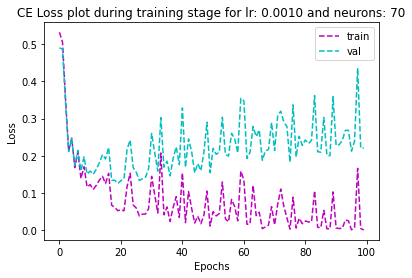

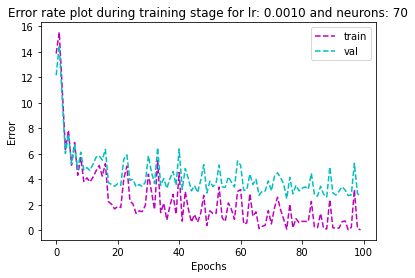

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0010 and Hidden layer size: 70

Epoch:    0, Train Loss: 0.5721, Val Loss: 0.5281, Train Accuracy: 85.16%, Validation Accuracy: 86.72%
Epoch:   10, Train Loss: 0.1201, Val Loss: 0.1617, Train Accuracy: 96.07%, Validation Accuracy: 95.16%
Epoch:   20, Train Loss: 0.0650, Val Loss: 0.1471, Train Accuracy: 97.82%, Validation Accuracy: 96.08%
Epoch:   30, Train Loss: 0.1882, Val Loss: 0.3247, Train Accuracy: 94.57%, Validation Accuracy: 93.36%
Epoch:   40, Train Loss: 0.0646, Val Loss: 0.2366, Train Accuracy: 97.98%, Validation Accuracy: 95.76%
Epoch:   50, Train Loss: 0.0495, Val Loss: 0.2147, Train Accuracy: 98.53%, Validation Accuracy: 96.13%
Epoch:   60, Train Loss: 0.0172, Val Loss: 0.1928, Train Accuracy: 99.42%, Validation Accuracy: 96.93%
Epoch:   70, Train Loss: 0.0278, Val Loss: 0.2309, Train Accuracy: 99.15%, Validation Accuracy: 96.60%
Epoch:   80, Train Lo

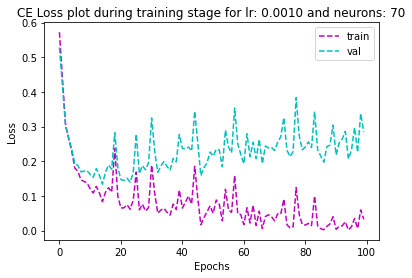

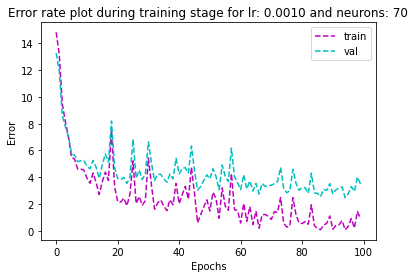

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0010 and Hidden layer size: 100

Epoch:    0, Train Loss: 0.4786, Val Loss: 0.4378, Train Accuracy: 86.81%, Validation Accuracy: 88.16%
Epoch:   10, Train Loss: 0.0785, Val Loss: 0.1213, Train Accuracy: 97.45%, Validation Accuracy: 96.50%
Epoch:   20, Train Loss: 0.1495, Val Loss: 0.2533, Train Accuracy: 95.24%, Validation Accuracy: 93.85%
Epoch:   30, Train Loss: 0.2091, Val Loss: 0.3332, Train Accuracy: 94.46%, Validation Accuracy: 93.17%
Epoch:   40, Train Loss: 0.0352, Val Loss: 0.1864, Train Accuracy: 98.96%, Validation Accuracy: 96.76%
Epoch:   50, Train Loss: 0.0284, Val Loss: 0.2069, Train Accuracy: 99.10%, Validation Accuracy: 96.58%
Epoch:   60, Train Loss: 0.0146, Val Loss: 0.2147, Train Accuracy: 99.53%, Validation Accuracy: 96.88%
Epoch:   70, Train Loss: 0.0000, Val Loss: 0.1474, Train Accuracy: 100.00%, Validation Accuracy: 97.88%
Epoch:   80, Train 

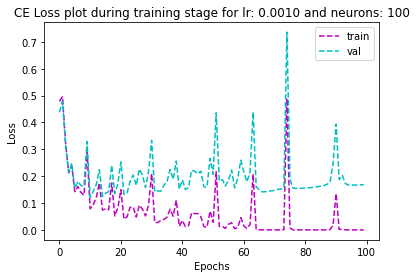

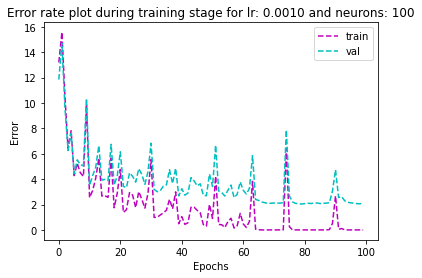

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0010 and Hidden layer size: 100

Epoch:    0, Train Loss: 0.4808, Val Loss: 0.4422, Train Accuracy: 86.94%, Validation Accuracy: 88.43%
Epoch:   10, Train Loss: 0.1191, Val Loss: 0.1661, Train Accuracy: 95.97%, Validation Accuracy: 94.94%
Epoch:   20, Train Loss: 0.0795, Val Loss: 0.1611, Train Accuracy: 97.39%, Validation Accuracy: 95.69%
Epoch:   30, Train Loss: 0.0231, Val Loss: 0.1427, Train Accuracy: 99.20%, Validation Accuracy: 96.93%
Epoch:   40, Train Loss: 0.0314, Val Loss: 0.1783, Train Accuracy: 98.96%, Validation Accuracy: 96.79%
Epoch:   50, Train Loss: 0.1369, Val Loss: 0.3256, Train Accuracy: 96.78%, Validation Accuracy: 94.60%
Epoch:   60, Train Loss: 0.1272, Val Loss: 0.3299, Train Accuracy: 97.64%, Validation Accuracy: 95.34%
Epoch:   70, Train Loss: 0.0060, Val Loss: 0.1967, Train Accuracy: 99.77%, Validation Accuracy: 97.24%
Epoch:   80, Train L

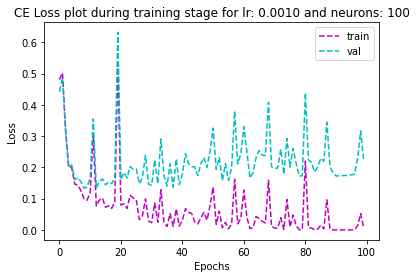

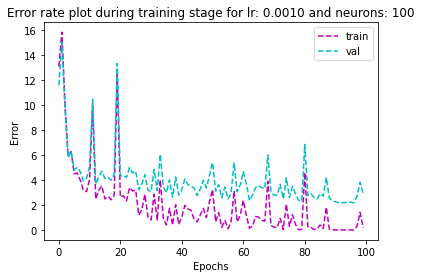

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0010 and Hidden layer size: 100

Epoch:    0, Train Loss: 0.4925, Val Loss: 0.4486, Train Accuracy: 86.57%, Validation Accuracy: 88.20%
Epoch:   10, Train Loss: 0.0905, Val Loss: 0.1352, Train Accuracy: 97.00%, Validation Accuracy: 95.82%
Epoch:   20, Train Loss: 0.1462, Val Loss: 0.2269, Train Accuracy: 95.46%, Validation Accuracy: 93.91%
Epoch:   30, Train Loss: 0.0510, Val Loss: 0.1435, Train Accuracy: 98.43%, Validation Accuracy: 96.69%
Epoch:   40, Train Loss: 0.0257, Val Loss: 0.1577, Train Accuracy: 99.10%, Validation Accuracy: 97.10%
Epoch:   50, Train Loss: 0.0455, Val Loss: 0.2249, Train Accuracy: 98.65%, Validation Accuracy: 96.55%
Epoch:   60, Train Loss: 0.0704, Val Loss: 0.2785, Train Accuracy: 98.33%, Validation Accuracy: 96.28%
Epoch:   70, Train Loss: 0.2247, Val Loss: 0.4399, Train Accuracy: 96.63%, Validation Accuracy: 94.50%
Epoch:   80, Train L

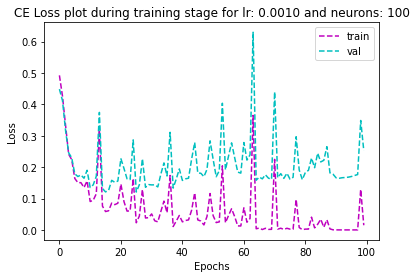

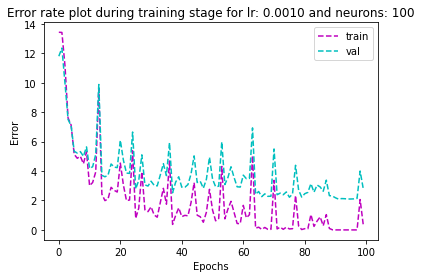

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0010 and Hidden layer size: 100

Epoch:    0, Train Loss: 0.4891, Val Loss: 0.4500, Train Accuracy: 86.68%, Validation Accuracy: 88.23%
Epoch:   10, Train Loss: 0.1292, Val Loss: 0.1766, Train Accuracy: 95.74%, Validation Accuracy: 94.78%
Epoch:   20, Train Loss: 0.1608, Val Loss: 0.2461, Train Accuracy: 95.34%, Validation Accuracy: 93.90%
Epoch:   30, Train Loss: 0.0997, Val Loss: 0.2223, Train Accuracy: 97.22%, Validation Accuracy: 95.13%
Epoch:   40, Train Loss: 0.0338, Val Loss: 0.1807, Train Accuracy: 98.86%, Validation Accuracy: 96.57%
Epoch:   50, Train Loss: 0.0335, Val Loss: 0.2028, Train Accuracy: 99.01%, Validation Accuracy: 97.05%
Epoch:   60, Train Loss: 0.0966, Val Loss: 0.3244, Train Accuracy: 97.58%, Validation Accuracy: 95.31%
Epoch:   70, Train Loss: 0.0080, Val Loss: 0.2066, Train Accuracy: 99.72%, Validation Accuracy: 97.25%
Epoch:   80, Train L

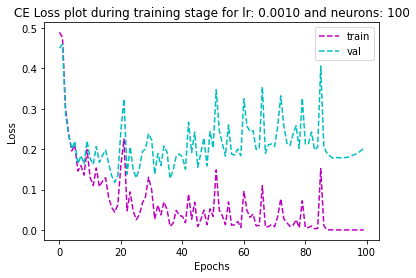

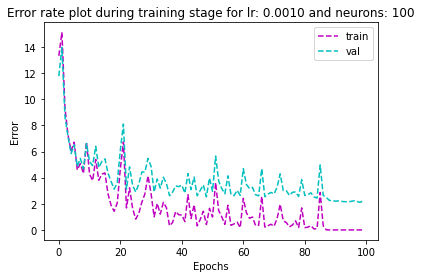

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0010 and Hidden layer size: 100

Epoch:    0, Train Loss: 0.4768, Val Loss: 0.4367, Train Accuracy: 86.87%, Validation Accuracy: 88.23%
Epoch:   10, Train Loss: 0.0946, Val Loss: 0.1407, Train Accuracy: 96.95%, Validation Accuracy: 96.10%
Epoch:   20, Train Loss: 0.0796, Val Loss: 0.1645, Train Accuracy: 97.18%, Validation Accuracy: 95.63%
Epoch:   30, Train Loss: 0.0755, Val Loss: 0.1901, Train Accuracy: 97.41%, Validation Accuracy: 95.98%
Epoch:   40, Train Loss: 0.1233, Val Loss: 0.2563, Train Accuracy: 96.93%, Validation Accuracy: 95.52%
Epoch:   50, Train Loss: 0.0578, Val Loss: 0.2373, Train Accuracy: 98.37%, Validation Accuracy: 96.08%
Epoch:   60, Train Loss: 0.0553, Val Loss: 0.2571, Train Accuracy: 98.56%, Validation Accuracy: 96.25%
Epoch:   70, Train Loss: 0.0061, Val Loss: 0.1814, Train Accuracy: 99.78%, Validation Accuracy: 97.45%
Epoch:   80, Train L

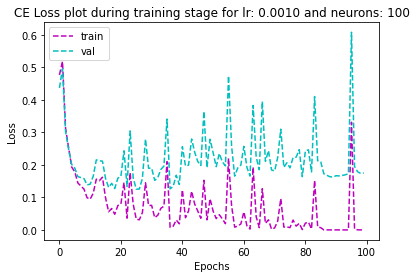

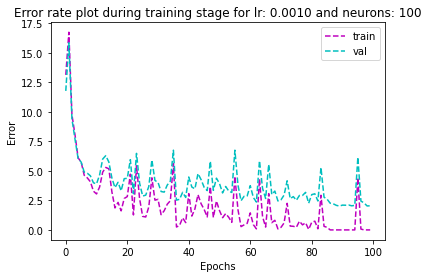

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0100 and Hidden layer size: 10

Epoch:    0, Train Loss: 0.6578, Val Loss: 0.6109, Train Accuracy: 78.23%, Validation Accuracy: 79.77%
Epoch:   10, Train Loss: 0.6097, Val Loss: 0.5940, Train Accuracy: 81.54%, Validation Accuracy: 82.47%
Epoch:   20, Train Loss: 1.0136, Val Loss: 1.0197, Train Accuracy: 73.13%, Validation Accuracy: 73.70%
Epoch:   30, Train Loss: 0.5502, Val Loss: 0.5513, Train Accuracy: 82.93%, Validation Accuracy: 83.77%
Epoch:   40, Train Loss: 0.7158, Val Loss: 0.7167, Train Accuracy: 79.51%, Validation Accuracy: 80.05%
Epoch:   50, Train Loss: 0.7299, Val Loss: 0.7765, Train Accuracy: 79.87%, Validation Accuracy: 79.99%
Epoch:   60, Train Loss: 0.7057, Val Loss: 0.7691, Train Accuracy: 81.36%, Validation Accuracy: 80.46%
Epoch:   70, Train Loss: 0.4836, Val Loss: 0.5316, Train Accuracy: 86.29%, Validation Accuracy: 85.97%
Epoch:   80, Train Lo

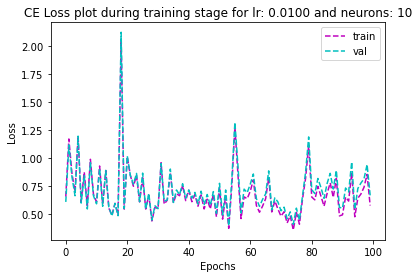

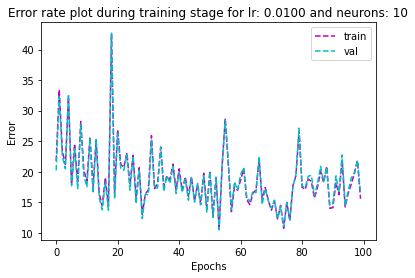

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0100 and Hidden layer size: 10

Epoch:    0, Train Loss: 0.6644, Val Loss: 0.6341, Train Accuracy: 81.22%, Validation Accuracy: 81.62%
Epoch:   10, Train Loss: 0.4876, Val Loss: 0.4787, Train Accuracy: 85.86%, Validation Accuracy: 86.50%
Epoch:   20, Train Loss: 0.2957, Val Loss: 0.3227, Train Accuracy: 91.12%, Validation Accuracy: 91.05%
Epoch:   30, Train Loss: 0.5474, Val Loss: 0.5924, Train Accuracy: 83.88%, Validation Accuracy: 83.64%
Epoch:   40, Train Loss: 0.4854, Val Loss: 0.5509, Train Accuracy: 87.56%, Validation Accuracy: 87.11%
Epoch:   50, Train Loss: 0.6133, Val Loss: 0.6905, Train Accuracy: 83.27%, Validation Accuracy: 83.17%
Epoch:   60, Train Loss: 0.6280, Val Loss: 0.7279, Train Accuracy: 83.68%, Validation Accuracy: 82.84%
Epoch:   70, Train Loss: 0.5280, Val Loss: 0.6481, Train Accuracy: 85.75%, Validation Accuracy: 85.30%
Epoch:   80, Train Lo

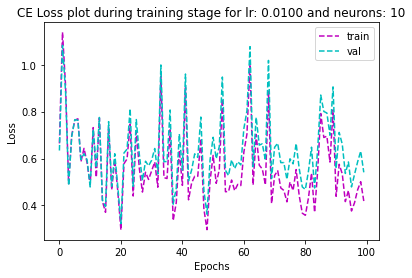

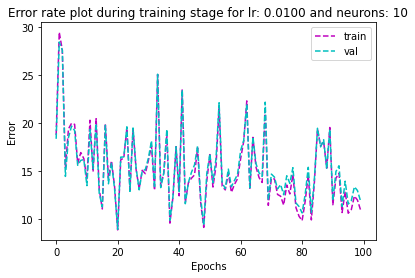

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0100 and Hidden layer size: 10

Epoch:    0, Train Loss: 0.6049, Val Loss: 0.5745, Train Accuracy: 81.13%, Validation Accuracy: 82.36%
Epoch:   10, Train Loss: 0.5100, Val Loss: 0.5397, Train Accuracy: 84.18%, Validation Accuracy: 84.19%
Epoch:   20, Train Loss: 0.7134, Val Loss: 0.7375, Train Accuracy: 81.26%, Validation Accuracy: 81.30%
Epoch:   30, Train Loss: 0.4109, Val Loss: 0.4805, Train Accuracy: 87.45%, Validation Accuracy: 86.83%
Epoch:   40, Train Loss: 0.6187, Val Loss: 0.6993, Train Accuracy: 83.39%, Validation Accuracy: 82.87%
Epoch:   50, Train Loss: 0.3147, Val Loss: 0.4220, Train Accuracy: 90.89%, Validation Accuracy: 90.24%
Epoch:   60, Train Loss: 0.4876, Val Loss: 0.6269, Train Accuracy: 86.79%, Validation Accuracy: 85.62%
Epoch:   70, Train Loss: 0.4104, Val Loss: 0.5214, Train Accuracy: 89.59%, Validation Accuracy: 89.55%
Epoch:   80, Train Lo

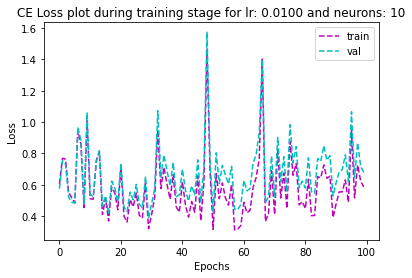

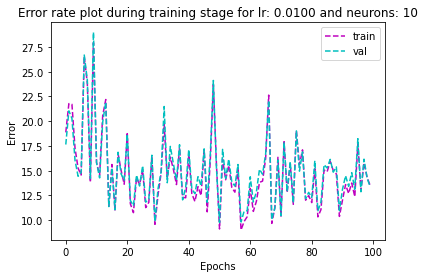

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0100 and Hidden layer size: 10

Epoch:    0, Train Loss: 1.1636, Val Loss: 1.1243, Train Accuracy: 64.67%, Validation Accuracy: 66.03%
Epoch:   10, Train Loss: 0.5177, Val Loss: 0.5258, Train Accuracy: 84.04%, Validation Accuracy: 84.86%
Epoch:   20, Train Loss: 0.4762, Val Loss: 0.5224, Train Accuracy: 86.76%, Validation Accuracy: 86.72%
Epoch:   30, Train Loss: 0.7436, Val Loss: 0.8016, Train Accuracy: 80.31%, Validation Accuracy: 79.84%
Epoch:   40, Train Loss: 0.5089, Val Loss: 0.5776, Train Accuracy: 86.32%, Validation Accuracy: 85.49%
Epoch:   50, Train Loss: 0.4122, Val Loss: 0.4828, Train Accuracy: 88.53%, Validation Accuracy: 88.17%
Epoch:   60, Train Loss: 0.4886, Val Loss: 0.5906, Train Accuracy: 86.56%, Validation Accuracy: 85.26%
Epoch:   70, Train Loss: 0.4641, Val Loss: 0.5615, Train Accuracy: 87.18%, Validation Accuracy: 86.77%
Epoch:   80, Train Lo

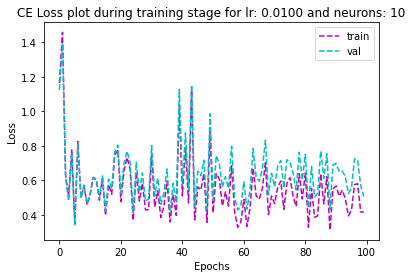

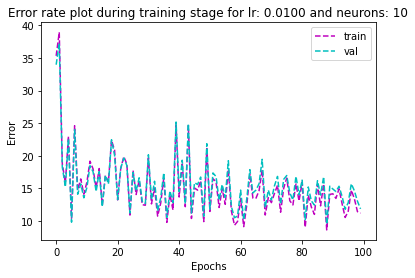

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0100 and Hidden layer size: 10

Epoch:    0, Train Loss: 0.9510, Val Loss: 0.9226, Train Accuracy: 69.33%, Validation Accuracy: 70.13%
Epoch:   10, Train Loss: 0.4017, Val Loss: 0.4186, Train Accuracy: 88.00%, Validation Accuracy: 87.79%
Epoch:   20, Train Loss: 0.6904, Val Loss: 0.7086, Train Accuracy: 83.89%, Validation Accuracy: 84.26%
Epoch:   30, Train Loss: 0.5345, Val Loss: 0.5807, Train Accuracy: 84.74%, Validation Accuracy: 84.32%
Epoch:   40, Train Loss: 0.5507, Val Loss: 0.6253, Train Accuracy: 85.91%, Validation Accuracy: 85.40%
Epoch:   50, Train Loss: 0.6946, Val Loss: 0.7607, Train Accuracy: 84.17%, Validation Accuracy: 84.11%
Epoch:   60, Train Loss: 0.4117, Val Loss: 0.5295, Train Accuracy: 88.67%, Validation Accuracy: 87.50%
Epoch:   70, Train Loss: 0.4197, Val Loss: 0.5158, Train Accuracy: 88.56%, Validation Accuracy: 87.74%
Epoch:   80, Train Lo

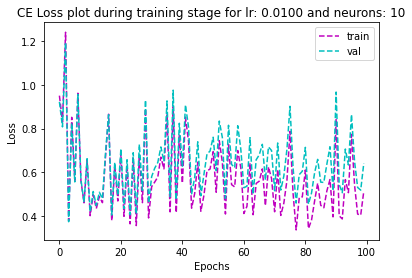

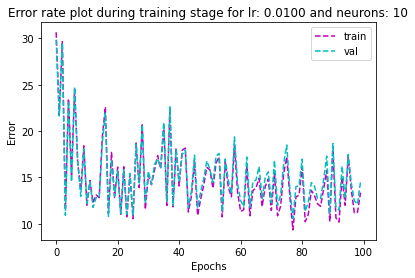

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0100 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.9797, Val Loss: 0.9325, Train Accuracy: 71.05%, Validation Accuracy: 71.87%
Epoch:   10, Train Loss: 0.3504, Val Loss: 0.4102, Train Accuracy: 90.76%, Validation Accuracy: 90.35%
Epoch:   20, Train Loss: 0.4082, Val Loss: 0.5022, Train Accuracy: 91.32%, Validation Accuracy: 91.19%
Epoch:   30, Train Loss: 0.4566, Val Loss: 0.6223, Train Accuracy: 90.19%, Validation Accuracy: 89.53%
Epoch:   40, Train Loss: 0.4145, Val Loss: 0.6716, Train Accuracy: 93.81%, Validation Accuracy: 93.34%
Epoch:   50, Train Loss: 0.5023, Val Loss: 0.8083, Train Accuracy: 92.76%, Validation Accuracy: 91.88%
Epoch:   60, Train Loss: 0.4712, Val Loss: 0.9042, Train Accuracy: 94.53%, Validation Accuracy: 93.10%
Epoch:   70, Train Loss: 0.1657, Val Loss: 0.5678, Train Accuracy: 97.14%, Validation Accuracy: 94.97%
Epoch:   80, Train Lo

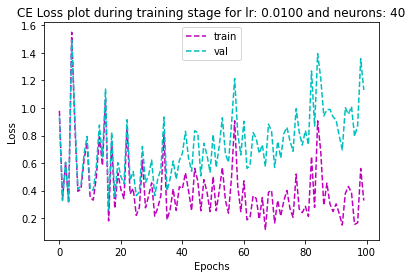

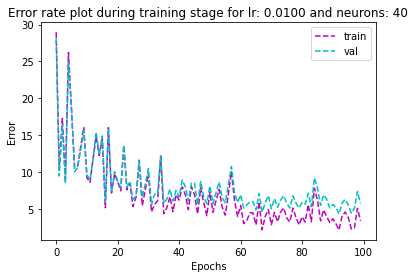

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0100 and Hidden layer size: 40

Epoch:    0, Train Loss: 1.4170, Val Loss: 1.3817, Train Accuracy: 64.57%, Validation Accuracy: 65.18%
Epoch:   10, Train Loss: 0.2914, Val Loss: 0.3101, Train Accuracy: 91.74%, Validation Accuracy: 91.99%
Epoch:   20, Train Loss: 0.7928, Val Loss: 0.8493, Train Accuracy: 87.62%, Validation Accuracy: 87.51%
Epoch:   30, Train Loss: 0.2725, Val Loss: 0.4526, Train Accuracy: 94.44%, Validation Accuracy: 93.39%
Epoch:   40, Train Loss: 0.2613, Val Loss: 0.4850, Train Accuracy: 95.17%, Validation Accuracy: 93.87%
Epoch:   50, Train Loss: 0.2346, Val Loss: 0.5258, Train Accuracy: 94.79%, Validation Accuracy: 92.95%
Epoch:   60, Train Loss: 0.2818, Val Loss: 0.6302, Train Accuracy: 95.45%, Validation Accuracy: 93.96%
Epoch:   70, Train Loss: 0.7316, Val Loss: 1.0503, Train Accuracy: 92.20%, Validation Accuracy: 91.13%
Epoch:   80, Train Lo

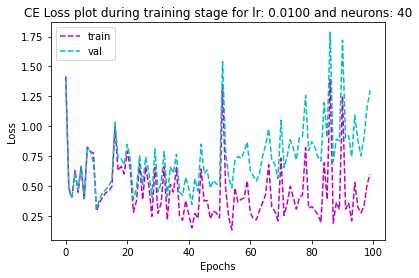

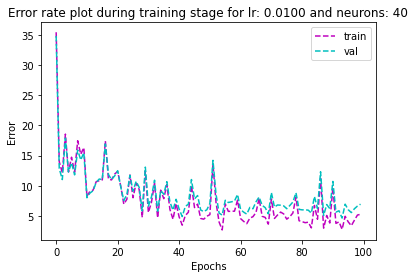

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0100 and Hidden layer size: 40

Epoch:    0, Train Loss: 1.1341, Val Loss: 1.1010, Train Accuracy: 66.99%, Validation Accuracy: 67.46%
Epoch:   10, Train Loss: 0.2610, Val Loss: 0.3147, Train Accuracy: 93.39%, Validation Accuracy: 93.42%
Epoch:   20, Train Loss: 0.2511, Val Loss: 0.3677, Train Accuracy: 94.18%, Validation Accuracy: 93.56%
Epoch:   30, Train Loss: 0.2494, Val Loss: 0.4496, Train Accuracy: 94.73%, Validation Accuracy: 93.82%
Epoch:   40, Train Loss: 0.7925, Val Loss: 1.1168, Train Accuracy: 89.92%, Validation Accuracy: 89.08%
Epoch:   50, Train Loss: 0.2076, Val Loss: 0.5905, Train Accuracy: 96.52%, Validation Accuracy: 94.79%
Epoch:   60, Train Loss: 0.3425, Val Loss: 0.8021, Train Accuracy: 95.61%, Validation Accuracy: 94.18%
Epoch:   70, Train Loss: 0.2191, Val Loss: 0.8168, Train Accuracy: 96.85%, Validation Accuracy: 94.75%
Epoch:   80, Train Lo

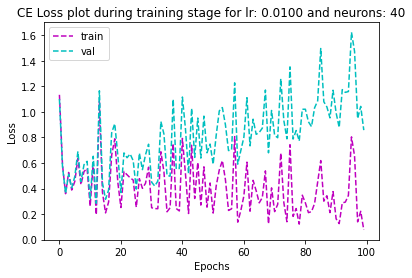

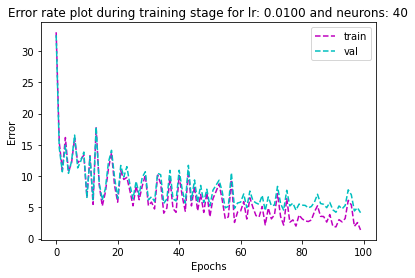

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0100 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.9037, Val Loss: 0.8720, Train Accuracy: 74.39%, Validation Accuracy: 75.40%
Epoch:   10, Train Loss: 0.3186, Val Loss: 0.3549, Train Accuracy: 92.36%, Validation Accuracy: 92.74%
Epoch:   20, Train Loss: 0.5203, Val Loss: 0.6031, Train Accuracy: 88.09%, Validation Accuracy: 88.06%
Epoch:   30, Train Loss: 0.7067, Val Loss: 0.8643, Train Accuracy: 88.97%, Validation Accuracy: 88.15%
Epoch:   40, Train Loss: 0.6129, Val Loss: 0.8360, Train Accuracy: 91.56%, Validation Accuracy: 90.98%
Epoch:   50, Train Loss: 0.4727, Val Loss: 0.7746, Train Accuracy: 93.38%, Validation Accuracy: 92.70%
Epoch:   60, Train Loss: 0.7085, Val Loss: 1.0849, Train Accuracy: 92.25%, Validation Accuracy: 91.27%
Epoch:   70, Train Loss: 0.2969, Val Loss: 0.8407, Train Accuracy: 95.85%, Validation Accuracy: 93.92%
Epoch:   80, Train Lo

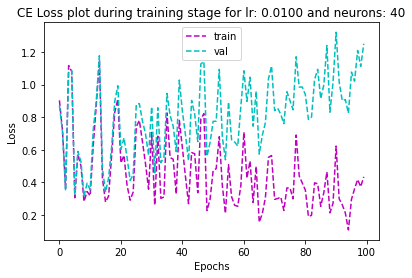

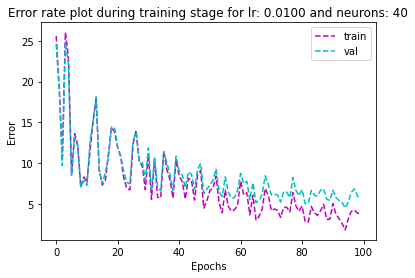

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0100 and Hidden layer size: 40

Epoch:    0, Train Loss: 0.9186, Val Loss: 0.8934, Train Accuracy: 73.41%, Validation Accuracy: 74.06%
Epoch:   10, Train Loss: 0.3938, Val Loss: 0.4729, Train Accuracy: 90.69%, Validation Accuracy: 90.77%
Epoch:   20, Train Loss: 0.3244, Val Loss: 0.4326, Train Accuracy: 92.72%, Validation Accuracy: 92.13%
Epoch:   30, Train Loss: 0.3612, Val Loss: 0.5783, Train Accuracy: 93.56%, Validation Accuracy: 92.56%
Epoch:   40, Train Loss: 0.6304, Val Loss: 0.8925, Train Accuracy: 92.29%, Validation Accuracy: 91.75%
Epoch:   50, Train Loss: 0.3490, Val Loss: 0.7177, Train Accuracy: 94.62%, Validation Accuracy: 93.22%
Epoch:   60, Train Loss: 0.3880, Val Loss: 0.7347, Train Accuracy: 95.55%, Validation Accuracy: 94.21%
Epoch:   70, Train Loss: 0.7211, Val Loss: 1.1295, Train Accuracy: 92.00%, Validation Accuracy: 91.28%
Epoch:   80, Train Lo

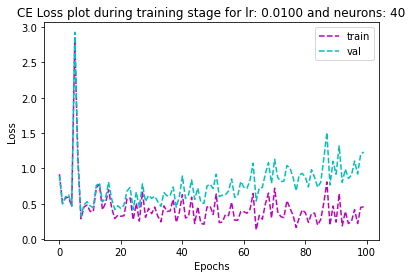

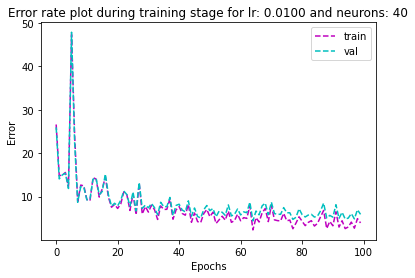

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0100 and Hidden layer size: 70

Epoch:    0, Train Loss: 0.6981, Val Loss: 0.6687, Train Accuracy: 80.73%, Validation Accuracy: 81.97%
Epoch:   10, Train Loss: 0.8605, Val Loss: 0.8526, Train Accuracy: 85.95%, Validation Accuracy: 86.32%
Epoch:   20, Train Loss: 0.2290, Val Loss: 0.3905, Train Accuracy: 94.84%, Validation Accuracy: 93.57%
Epoch:   30, Train Loss: 0.1848, Val Loss: 0.4153, Train Accuracy: 95.99%, Validation Accuracy: 94.68%
Epoch:   40, Train Loss: 0.3390, Val Loss: 0.7087, Train Accuracy: 95.57%, Validation Accuracy: 93.95%
Epoch:   50, Train Loss: 0.3531, Val Loss: 0.7574, Train Accuracy: 94.84%, Validation Accuracy: 93.50%
Epoch:   60, Train Loss: 0.7699, Val Loss: 1.3385, Train Accuracy: 93.80%, Validation Accuracy: 92.58%
Epoch:   70, Train Loss: 0.2058, Val Loss: 0.8044, Train Accuracy: 97.99%, Validation Accuracy: 95.88%
Epoch:   80, Train Lo

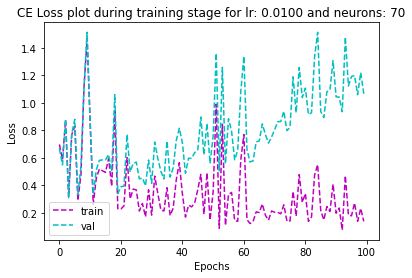

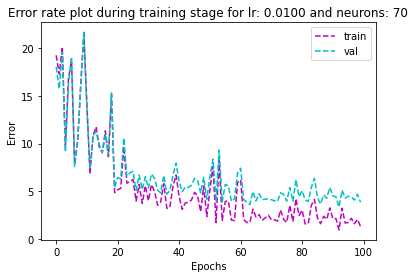

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0100 and Hidden layer size: 70

Epoch:    0, Train Loss: 0.7466, Val Loss: 0.6987, Train Accuracy: 76.93%, Validation Accuracy: 78.58%
Epoch:   10, Train Loss: 0.3839, Val Loss: 0.4568, Train Accuracy: 91.07%, Validation Accuracy: 90.82%
Epoch:   20, Train Loss: 0.2798, Val Loss: 0.3827, Train Accuracy: 93.51%, Validation Accuracy: 92.86%
Epoch:   30, Train Loss: 0.1950, Val Loss: 0.4176, Train Accuracy: 96.21%, Validation Accuracy: 94.74%
Epoch:   40, Train Loss: 0.3967, Val Loss: 0.6819, Train Accuracy: 94.48%, Validation Accuracy: 93.02%
Epoch:   50, Train Loss: 0.8367, Val Loss: 1.2822, Train Accuracy: 92.62%, Validation Accuracy: 91.18%
Epoch:   60, Train Loss: 0.3522, Val Loss: 0.9745, Train Accuracy: 94.98%, Validation Accuracy: 93.06%
Epoch:   70, Train Loss: 0.2656, Val Loss: 1.0149, Train Accuracy: 96.11%, Validation Accuracy: 94.21%
Epoch:   80, Train Lo

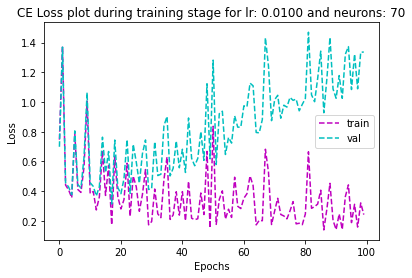

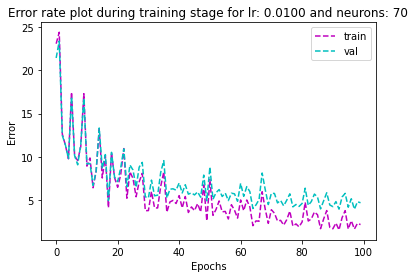

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0100 and Hidden layer size: 70

Epoch:    0, Train Loss: 1.4227, Val Loss: 1.4143, Train Accuracy: 64.90%, Validation Accuracy: 64.99%
Epoch:   10, Train Loss: 0.4797, Val Loss: 0.5329, Train Accuracy: 88.98%, Validation Accuracy: 88.64%
Epoch:   20, Train Loss: 0.2819, Val Loss: 0.4527, Train Accuracy: 94.71%, Validation Accuracy: 93.34%
Epoch:   30, Train Loss: 0.3282, Val Loss: 0.5342, Train Accuracy: 94.54%, Validation Accuracy: 93.24%
Epoch:   40, Train Loss: 0.3450, Val Loss: 0.6855, Train Accuracy: 94.67%, Validation Accuracy: 92.84%
Epoch:   50, Train Loss: 0.4172, Val Loss: 0.8537, Train Accuracy: 94.95%, Validation Accuracy: 93.44%
Epoch:   60, Train Loss: 0.2818, Val Loss: 0.8468, Train Accuracy: 96.09%, Validation Accuracy: 93.44%
Epoch:   70, Train Loss: 0.6705, Val Loss: 1.3205, Train Accuracy: 94.74%, Validation Accuracy: 92.89%
Epoch:   80, Train Lo

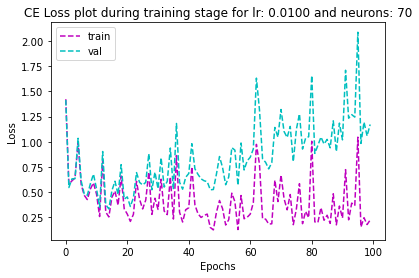

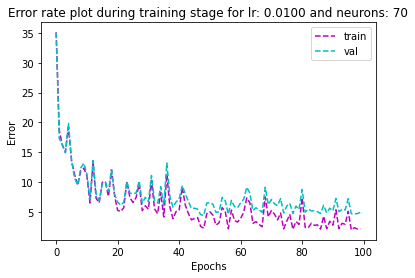

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0100 and Hidden layer size: 70

Epoch:    0, Train Loss: 1.5895, Val Loss: 1.5647, Train Accuracy: 61.09%, Validation Accuracy: 61.12%
Epoch:   10, Train Loss: 0.4743, Val Loss: 0.5088, Train Accuracy: 88.35%, Validation Accuracy: 88.51%
Epoch:   20, Train Loss: 0.7824, Val Loss: 0.8786, Train Accuracy: 87.20%, Validation Accuracy: 87.15%
Epoch:   30, Train Loss: 0.2792, Val Loss: 0.4714, Train Accuracy: 94.40%, Validation Accuracy: 93.35%
Epoch:   40, Train Loss: 0.5883, Val Loss: 0.8691, Train Accuracy: 92.13%, Validation Accuracy: 91.14%
Epoch:   50, Train Loss: 0.1299, Val Loss: 0.5037, Train Accuracy: 97.79%, Validation Accuracy: 95.88%
Epoch:   60, Train Loss: 0.2707, Val Loss: 0.8537, Train Accuracy: 96.99%, Validation Accuracy: 95.13%
Epoch:   70, Train Loss: 0.3658, Val Loss: 1.0757, Train Accuracy: 96.54%, Validation Accuracy: 94.41%
Epoch:   80, Train Lo

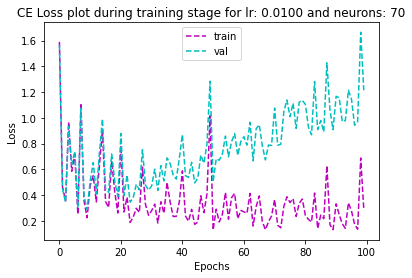

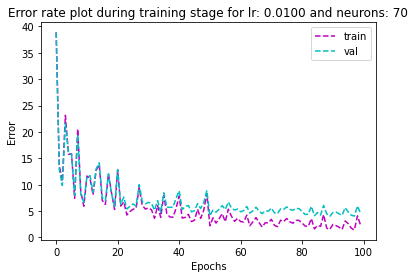

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0100 and Hidden layer size: 70

Epoch:    0, Train Loss: 1.8036, Val Loss: 1.7602, Train Accuracy: 53.06%, Validation Accuracy: 52.92%
Epoch:   10, Train Loss: 0.4017, Val Loss: 0.4226, Train Accuracy: 91.21%, Validation Accuracy: 91.49%
Epoch:   20, Train Loss: 0.2400, Val Loss: 0.4298, Train Accuracy: 94.96%, Validation Accuracy: 93.90%
Epoch:   30, Train Loss: 0.2679, Val Loss: 0.4975, Train Accuracy: 95.12%, Validation Accuracy: 93.74%
Epoch:   40, Train Loss: 0.6567, Val Loss: 0.9128, Train Accuracy: 90.81%, Validation Accuracy: 90.06%
Epoch:   50, Train Loss: 0.2309, Val Loss: 0.5969, Train Accuracy: 96.32%, Validation Accuracy: 94.61%
Epoch:   60, Train Loss: 0.3768, Val Loss: 0.8525, Train Accuracy: 95.14%, Validation Accuracy: 93.58%
Epoch:   70, Train Loss: 0.2650, Val Loss: 0.8319, Train Accuracy: 96.41%, Validation Accuracy: 94.83%
Epoch:   80, Train Lo

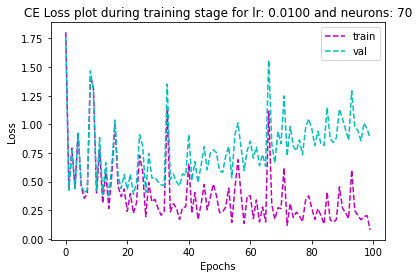

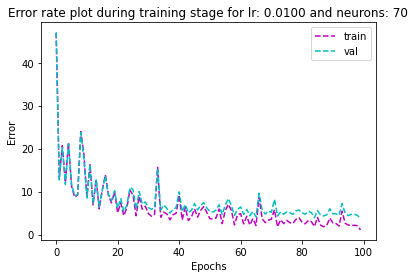

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.0100 and Hidden layer size: 100

Epoch:    0, Train Loss: 0.5857, Val Loss: 0.5631, Train Accuracy: 82.88%, Validation Accuracy: 83.73%
Epoch:   10, Train Loss: 0.4964, Val Loss: 0.5384, Train Accuracy: 91.21%, Validation Accuracy: 90.93%
Epoch:   20, Train Loss: 0.4713, Val Loss: 0.6129, Train Accuracy: 91.94%, Validation Accuracy: 91.30%
Epoch:   30, Train Loss: 0.2134, Val Loss: 0.4684, Train Accuracy: 96.03%, Validation Accuracy: 94.84%
Epoch:   40, Train Loss: 0.3397, Val Loss: 0.7183, Train Accuracy: 95.93%, Validation Accuracy: 94.49%
Epoch:   50, Train Loss: 0.3389, Val Loss: 0.8359, Train Accuracy: 96.47%, Validation Accuracy: 94.64%
Epoch:   60, Train Loss: 0.3896, Val Loss: 1.0552, Train Accuracy: 96.47%, Validation Accuracy: 94.06%
Epoch:   70, Train Loss: 0.2016, Val Loss: 0.7881, Train Accuracy: 97.74%, Validation Accuracy: 95.91%
Epoch:   80, Train L

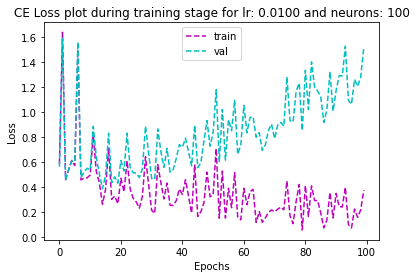

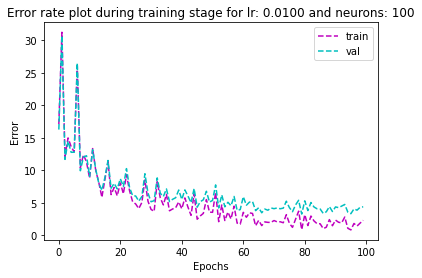

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.0100 and Hidden layer size: 100

Epoch:    0, Train Loss: 1.9261, Val Loss: 1.8813, Train Accuracy: 54.62%, Validation Accuracy: 54.99%
Epoch:   10, Train Loss: 0.4873, Val Loss: 0.5753, Train Accuracy: 90.55%, Validation Accuracy: 90.18%
Epoch:   20, Train Loss: 0.4025, Val Loss: 0.5429, Train Accuracy: 91.88%, Validation Accuracy: 91.56%
Epoch:   30, Train Loss: 0.2836, Val Loss: 0.5339, Train Accuracy: 95.05%, Validation Accuracy: 93.42%
Epoch:   40, Train Loss: 0.6801, Val Loss: 0.9974, Train Accuracy: 92.19%, Validation Accuracy: 91.02%
Epoch:   50, Train Loss: 0.1397, Val Loss: 0.5752, Train Accuracy: 97.94%, Validation Accuracy: 95.78%
Epoch:   60, Train Loss: 0.2920, Val Loss: 0.8784, Train Accuracy: 96.90%, Validation Accuracy: 94.86%
Epoch:   70, Train Loss: 0.3204, Val Loss: 0.9237, Train Accuracy: 96.63%, Validation Accuracy: 94.48%
Epoch:   80, Train L

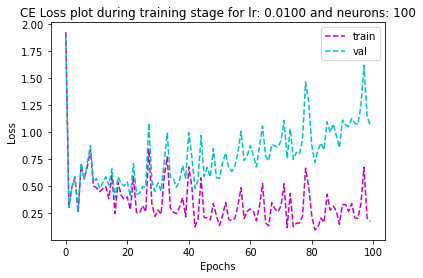

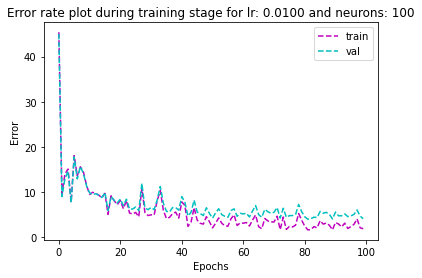

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.0100 and Hidden layer size: 100

Epoch:    0, Train Loss: 1.1235, Val Loss: 1.0623, Train Accuracy: 66.84%, Validation Accuracy: 67.80%
Epoch:   10, Train Loss: 0.3158, Val Loss: 0.3790, Train Accuracy: 91.23%, Validation Accuracy: 91.23%
Epoch:   20, Train Loss: 0.5854, Val Loss: 0.7785, Train Accuracy: 89.80%, Validation Accuracy: 88.57%
Epoch:   30, Train Loss: 0.2942, Val Loss: 0.5317, Train Accuracy: 94.59%, Validation Accuracy: 93.16%
Epoch:   40, Train Loss: 0.2408, Val Loss: 0.5624, Train Accuracy: 96.24%, Validation Accuracy: 94.52%
Epoch:   50, Train Loss: 0.2362, Val Loss: 0.6873, Train Accuracy: 96.66%, Validation Accuracy: 94.95%
Epoch:   60, Train Loss: 0.2908, Val Loss: 0.8702, Train Accuracy: 96.46%, Validation Accuracy: 94.27%
Epoch:   70, Train Loss: 0.2829, Val Loss: 1.0870, Train Accuracy: 97.11%, Validation Accuracy: 94.56%
Epoch:   80, Train L

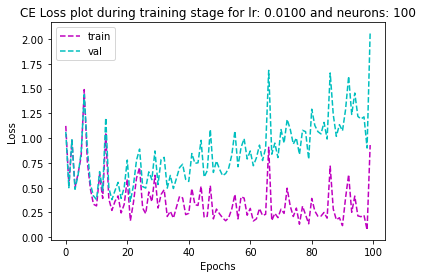

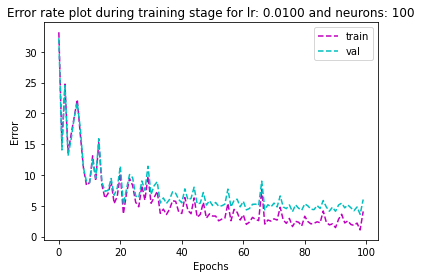

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.0100 and Hidden layer size: 100

Epoch:    0, Train Loss: 2.1629, Val Loss: 2.1028, Train Accuracy: 56.19%, Validation Accuracy: 57.05%
Epoch:   10, Train Loss: 0.6051, Val Loss: 0.6264, Train Accuracy: 87.71%, Validation Accuracy: 88.26%
Epoch:   20, Train Loss: 0.9372, Val Loss: 1.0181, Train Accuracy: 87.42%, Validation Accuracy: 87.59%
Epoch:   30, Train Loss: 0.2354, Val Loss: 0.4704, Train Accuracy: 95.95%, Validation Accuracy: 94.23%
Epoch:   40, Train Loss: 0.5500, Val Loss: 0.8085, Train Accuracy: 93.86%, Validation Accuracy: 92.50%
Epoch:   50, Train Loss: 0.1702, Val Loss: 0.6085, Train Accuracy: 97.50%, Validation Accuracy: 95.33%
Epoch:   60, Train Loss: 0.2256, Val Loss: 0.6470, Train Accuracy: 97.13%, Validation Accuracy: 95.31%
Epoch:   70, Train Loss: 0.2969, Val Loss: 0.8686, Train Accuracy: 96.60%, Validation Accuracy: 94.52%
Epoch:   80, Train L

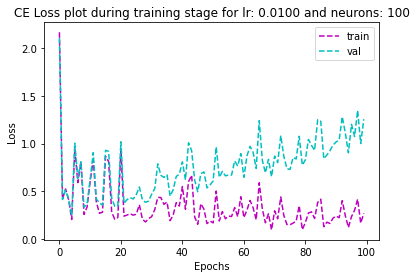

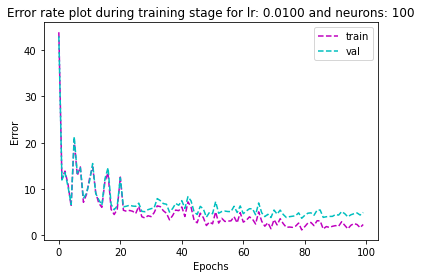

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.0100 and Hidden layer size: 100

Epoch:    0, Train Loss: 1.1325, Val Loss: 1.0963, Train Accuracy: 68.15%, Validation Accuracy: 69.54%
Epoch:   10, Train Loss: 0.9959, Val Loss: 1.0979, Train Accuracy: 83.63%, Validation Accuracy: 84.38%
Epoch:   20, Train Loss: 0.3186, Val Loss: 0.5253, Train Accuracy: 93.94%, Validation Accuracy: 92.54%
Epoch:   30, Train Loss: 0.3644, Val Loss: 0.6182, Train Accuracy: 94.34%, Validation Accuracy: 93.15%
Epoch:   40, Train Loss: 0.2559, Val Loss: 0.6362, Train Accuracy: 96.51%, Validation Accuracy: 94.78%
Epoch:   50, Train Loss: 0.5506, Val Loss: 1.0940, Train Accuracy: 94.83%, Validation Accuracy: 93.10%
Epoch:   60, Train Loss: 0.6726, Val Loss: 1.4850, Train Accuracy: 94.27%, Validation Accuracy: 92.08%
Epoch:   70, Train Loss: 0.2543, Val Loss: 1.0710, Train Accuracy: 97.53%, Validation Accuracy: 95.31%
Epoch:   80, Train L

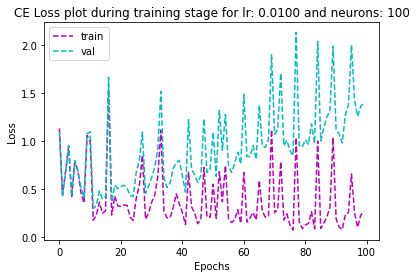

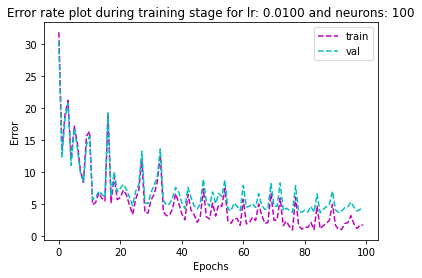

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.1000 and Hidden layer size: 10

Epoch:    0, Train Loss: 3.0563, Val Loss: 2.9972, Train Accuracy: 39.67%, Validation Accuracy: 39.90%
Epoch:   10, Train Loss: 2.1002, Val Loss: 2.2496, Train Accuracy: 20.37%, Validation Accuracy: 19.84%
Epoch:   20, Train Loss: 2.1166, Val Loss: 2.1547, Train Accuracy: 19.31%, Validation Accuracy: 19.04%
Epoch:   30, Train Loss: 2.0721, Val Loss: 2.1878, Train Accuracy: 19.98%, Validation Accuracy: 19.23%
Epoch:   40, Train Loss: 2.2891, Val Loss: 2.3087, Train Accuracy: 10.71%, Validation Accuracy: 10.14%
Epoch:   50, Train Loss: 2.0941, Val Loss: 2.2695, Train Accuracy: 19.67%, Validation Accuracy: 19.26%
Epoch:   60, Train Loss: 2.3432, Val Loss: 2.3500, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   70, Train Loss: 2.3667, Val Loss: 2.3753, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   80, Train Loss: 

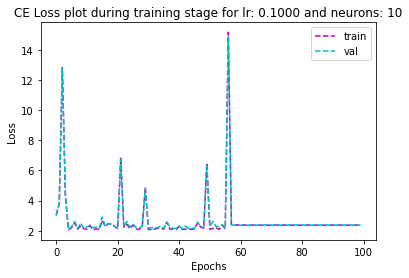

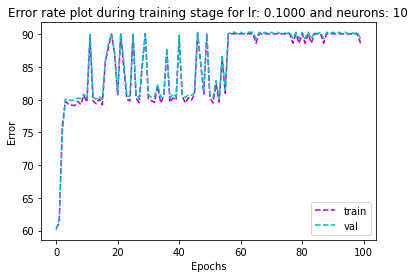

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.1000 and Hidden layer size: 10

Epoch:    0, Train Loss: 2.0002, Val Loss: 2.0195, Train Accuracy: 58.61%, Validation Accuracy: 58.76%
Epoch:   10, Train Loss: 2.1626, Val Loss: 2.1548, Train Accuracy: 19.38%, Validation Accuracy: 18.86%
Epoch:   20, Train Loss: 2.2525, Val Loss: 2.2292, Train Accuracy: 16.81%, Validation Accuracy: 16.66%
Epoch:   30, Train Loss: 2.3483, Val Loss: 2.3263, Train Accuracy: 13.96%, Validation Accuracy: 14.20%
Epoch:   40, Train Loss: 2.1880, Val Loss: 2.3688, Train Accuracy: 18.59%, Validation Accuracy: 18.61%
Epoch:   50, Train Loss: 2.1959, Val Loss: 2.2385, Train Accuracy: 17.99%, Validation Accuracy: 18.31%
Epoch:   60, Train Loss: 4.9206, Val Loss: 5.2225, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   70, Train Loss: 2.3523, Val Loss: 2.3534, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   80, Train Loss

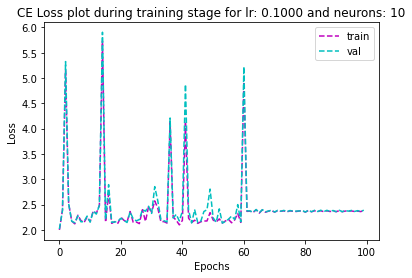

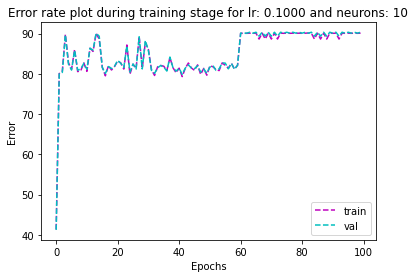

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.1000 and Hidden layer size: 10

Epoch:    0, Train Loss: 1.2394, Val Loss: 1.2112, Train Accuracy: 55.11%, Validation Accuracy: 56.35%
Epoch:   10, Train Loss: 2.2078, Val Loss: 2.2114, Train Accuracy: 17.17%, Validation Accuracy: 17.40%
Epoch:   20, Train Loss: 7.2714, Val Loss: 7.9131, Train Accuracy: 10.21%, Validation Accuracy: 10.32%
Epoch:   30, Train Loss: 2.3648, Val Loss: 2.3658, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   40, Train Loss: 2.3634, Val Loss: 2.3643, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   50, Train Loss: 2.3552, Val Loss: 2.3557, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   60, Train Loss: 2.3678, Val Loss: 2.3689, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   70, Train Loss: 2.3584, Val Loss: 2.3595, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   80, Train Lo

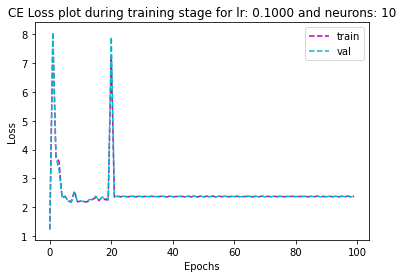

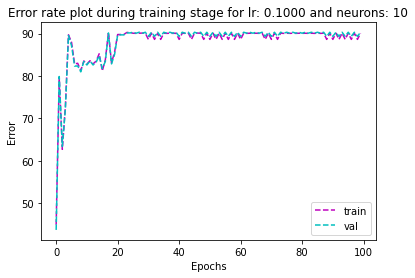

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.1000 and Hidden layer size: 10

Epoch:    0, Train Loss: 6.8142, Val Loss: 6.7368, Train Accuracy: 33.34%, Validation Accuracy: 33.04%
Epoch:   10, Train Loss: 2.3959, Val Loss: 2.3955, Train Accuracy: 9.72%, Validation Accuracy: 9.83%
Epoch:   20, Train Loss: 2.3775, Val Loss: 2.3875, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   30, Train Loss: 2.3848, Val Loss: 2.3946, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   40, Train Loss: 2.3775, Val Loss: 2.3872, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   50, Train Loss: 2.3711, Val Loss: 2.3799, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   60, Train Loss: 2.3699, Val Loss: 2.3787, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   70, Train Loss: 2.3708, Val Loss: 2.3800, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   80, Train Loss: 2.3724, Va

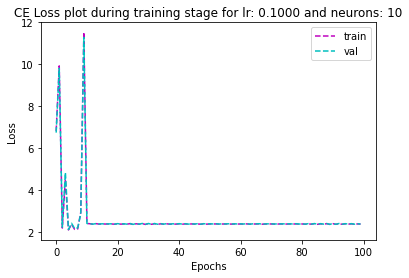

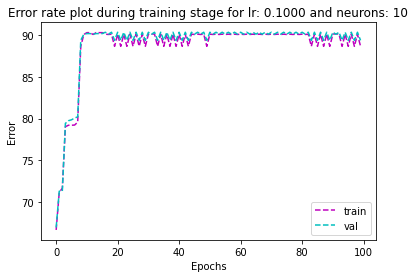

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.1000 and Hidden layer size: 10

Epoch:    0, Train Loss: 3.6611, Val Loss: 3.6884, Train Accuracy: 35.84%, Validation Accuracy: 35.47%
Epoch:   10, Train Loss: 2.4007, Val Loss: 2.4022, Train Accuracy: 9.72%, Validation Accuracy: 9.83%
Epoch:   20, Train Loss: 2.4066, Val Loss: 2.4083, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   30, Train Loss: 2.4076, Val Loss: 2.4093, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   40, Train Loss: 2.4084, Val Loss: 2.4101, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   50, Train Loss: 2.4092, Val Loss: 2.4109, Train Accuracy: 9.72%, Validation Accuracy: 9.83%
Epoch:   60, Train Loss: 2.4103, Val Loss: 2.4121, Train Accuracy: 9.72%, Validation Accuracy: 9.83%
Epoch:   70, Train Loss: 2.4119, Val Loss: 2.4137, Train Accuracy: 9.72%, Validation Accuracy: 9.83%
Epoch:   80, Train Loss: 2.4151, Va

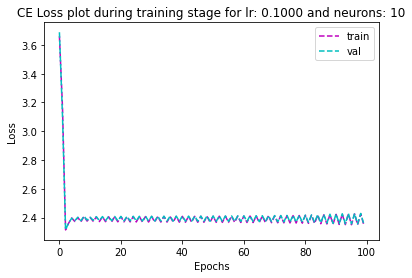

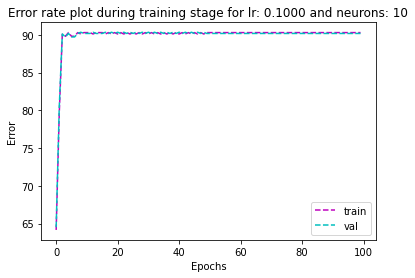

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.1000 and Hidden layer size: 40

Epoch:    0, Train Loss: 1.7974, Val Loss: 1.7094, Train Accuracy: 57.29%, Validation Accuracy: 58.34%
Epoch:   10, Train Loss: 1.9325, Val Loss: 2.0046, Train Accuracy: 26.85%, Validation Accuracy: 27.05%
Epoch:   20, Train Loss: 2.1002, Val Loss: 2.1543, Train Accuracy: 19.92%, Validation Accuracy: 19.25%
Epoch:   30, Train Loss: 2.1139, Val Loss: 2.2641, Train Accuracy: 20.24%, Validation Accuracy: 19.48%
Epoch:   40, Train Loss: 2.3566, Val Loss: 2.3653, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   50, Train Loss: 2.0897, Val Loss: 2.1921, Train Accuracy: 20.13%, Validation Accuracy: 19.65%
Epoch:   60, Train Loss: 2.2555, Val Loss: 2.4578, Train Accuracy: 20.47%, Validation Accuracy: 19.90%
Epoch:   70, Train Loss: 2.1475, Val Loss: 2.1478, Train Accuracy: 17.84%, Validation Accuracy: 17.80%
Epoch:   80, Train Lo

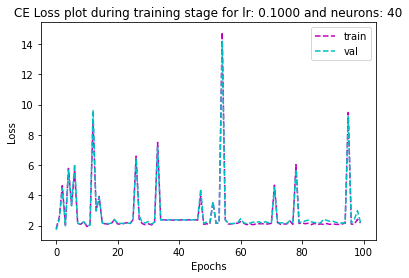

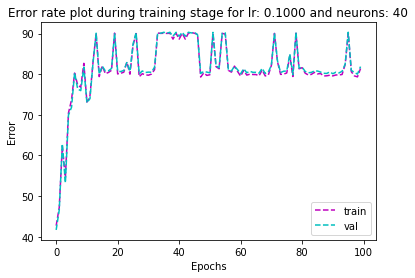

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.1000 and Hidden layer size: 40

Epoch:    0, Train Loss: 4.1445, Val Loss: 4.4008, Train Accuracy: 52.70%, Validation Accuracy: 52.30%
Epoch:   10, Train Loss: 2.1531, Val Loss: 2.1890, Train Accuracy: 18.82%, Validation Accuracy: 18.78%
Epoch:   20, Train Loss: 2.3197, Val Loss: 2.4777, Train Accuracy: 17.32%, Validation Accuracy: 17.46%
Epoch:   30, Train Loss: 2.1840, Val Loss: 2.2948, Train Accuracy: 21.50%, Validation Accuracy: 21.02%
Epoch:   40, Train Loss: 2.1643, Val Loss: 2.1871, Train Accuracy: 18.14%, Validation Accuracy: 17.71%
Epoch:   50, Train Loss: 2.1000, Val Loss: 2.1451, Train Accuracy: 19.98%, Validation Accuracy: 19.40%
Epoch:   60, Train Loss: 2.0921, Val Loss: 2.2031, Train Accuracy: 20.24%, Validation Accuracy: 19.65%
Epoch:   70, Train Loss: 2.0750, Val Loss: 2.2239, Train Accuracy: 20.45%, Validation Accuracy: 19.81%
Epoch:   80, Train Lo

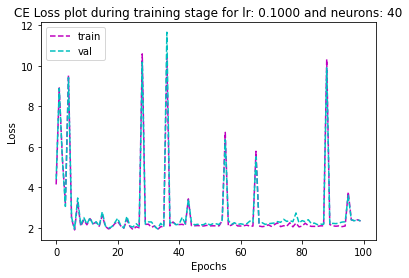

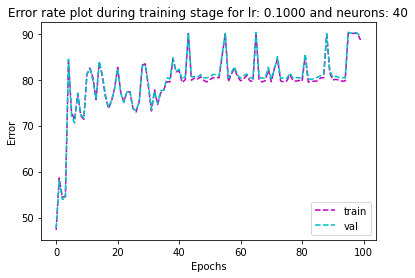

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.1000 and Hidden layer size: 40

Epoch:    0, Train Loss: 3.2840, Val Loss: 3.1501, Train Accuracy: 56.51%, Validation Accuracy: 57.05%
Epoch:   10, Train Loss: 2.0988, Val Loss: 2.1149, Train Accuracy: 20.07%, Validation Accuracy: 19.60%
Epoch:   20, Train Loss: 2.0393, Val Loss: 2.0594, Train Accuracy: 20.08%, Validation Accuracy: 19.69%
Epoch:   30, Train Loss: 2.5996, Val Loss: 2.6540, Train Accuracy: 13.80%, Validation Accuracy: 13.36%
Epoch:   40, Train Loss: 2.3471, Val Loss: 2.3511, Train Accuracy: 11.21%, Validation Accuracy: 11.16%
Epoch:   50, Train Loss: 2.3376, Val Loss: 2.3898, Train Accuracy: 20.35%, Validation Accuracy: 19.64%
Epoch:   60, Train Loss: 4.6628, Val Loss: 4.5178, Train Accuracy: 9.90%, Validation Accuracy: 9.68%
Epoch:   70, Train Loss: 2.1382, Val Loss: 2.3304, Train Accuracy: 20.25%, Validation Accuracy: 19.52%
Epoch:   80, Train Loss

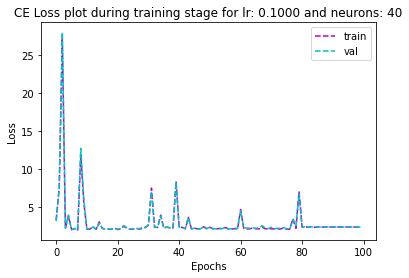

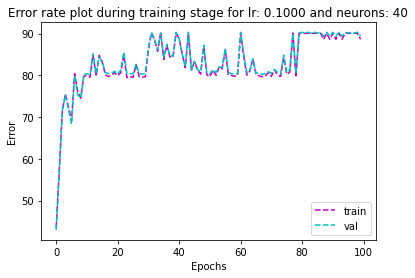

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.1000 and Hidden layer size: 40

Epoch:    0, Train Loss: 6.6334, Val Loss: 6.7514, Train Accuracy: 33.59%, Validation Accuracy: 33.21%
Epoch:   10, Train Loss: 2.2487, Val Loss: 2.3688, Train Accuracy: 18.96%, Validation Accuracy: 18.43%
Epoch:   20, Train Loss: 3.2706, Val Loss: 3.1821, Train Accuracy: 9.72%, Validation Accuracy: 9.81%
Epoch:   30, Train Loss: 2.4147, Val Loss: 2.4151, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   40, Train Loss: 2.3533, Val Loss: 2.3539, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   50, Train Loss: 2.3618, Val Loss: 2.3627, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   60, Train Loss: 2.3657, Val Loss: 2.3669, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   70, Train Loss: 2.3652, Val Loss: 2.3662, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   80, Train Loss: 2.

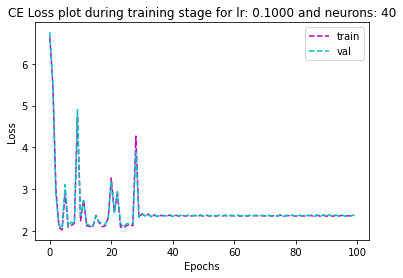

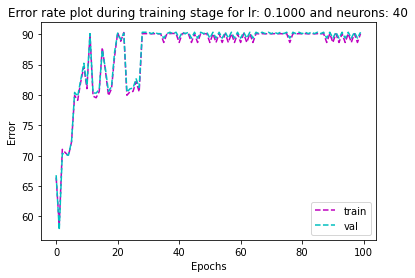

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.1000 and Hidden layer size: 40

Epoch:    0, Train Loss: 6.1911, Val Loss: 6.2902, Train Accuracy: 47.52%, Validation Accuracy: 47.39%
Epoch:   10, Train Loss: 1.7864, Val Loss: 2.0055, Train Accuracy: 36.26%, Validation Accuracy: 36.64%
Epoch:   20, Train Loss: 2.9818, Val Loss: 3.4391, Train Accuracy: 24.21%, Validation Accuracy: 25.46%
Epoch:   30, Train Loss: 3.8165, Val Loss: 4.3984, Train Accuracy: 27.11%, Validation Accuracy: 28.00%
Epoch:   40, Train Loss: 2.1328, Val Loss: 2.3115, Train Accuracy: 17.15%, Validation Accuracy: 17.72%
Epoch:   50, Train Loss: 2.3660, Val Loss: 2.3537, Train Accuracy: 10.36%, Validation Accuracy: 10.92%
Epoch:   60, Train Loss: 2.1419, Val Loss: 2.4132, Train Accuracy: 17.19%, Validation Accuracy: 17.73%
Epoch:   70, Train Loss: 2.1817, Val Loss: 2.2083, Train Accuracy: 16.91%, Validation Accuracy: 17.35%
Epoch:   80, Train Lo

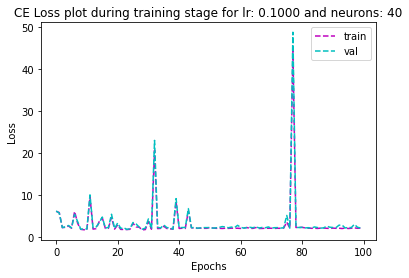

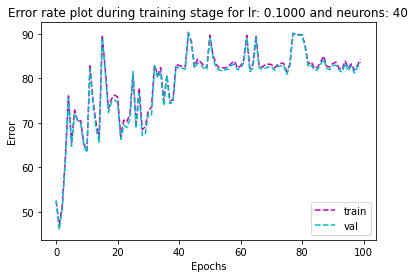

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.1000 and Hidden layer size: 70

Epoch:    0, Train Loss: 5.6479, Val Loss: 5.7247, Train Accuracy: 45.13%, Validation Accuracy: 45.31%
Epoch:   10, Train Loss: 1.9567, Val Loss: 2.1899, Train Accuracy: 26.87%, Validation Accuracy: 27.47%
Epoch:   20, Train Loss: 2.1413, Val Loss: 2.1829, Train Accuracy: 21.92%, Validation Accuracy: 22.45%
Epoch:   30, Train Loss: 2.1567, Val Loss: 2.1469, Train Accuracy: 21.37%, Validation Accuracy: 21.59%
Epoch:   40, Train Loss: 1.9601, Val Loss: 2.2776, Train Accuracy: 25.17%, Validation Accuracy: 25.55%
Epoch:   50, Train Loss: 1.9469, Val Loss: 1.9915, Train Accuracy: 25.08%, Validation Accuracy: 25.66%
Epoch:   60, Train Loss: 2.0199, Val Loss: 2.1620, Train Accuracy: 23.03%, Validation Accuracy: 23.71%
Epoch:   70, Train Loss: 2.0177, Val Loss: 2.1369, Train Accuracy: 23.15%, Validation Accuracy: 23.05%
Epoch:   80, Train Lo

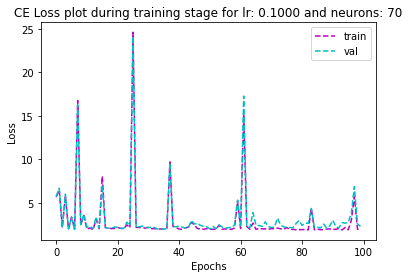

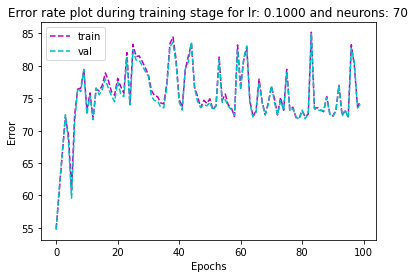

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.1000 and Hidden layer size: 70

Epoch:    0, Train Loss: 2.1228, Val Loss: 2.0413, Train Accuracy: 44.70%, Validation Accuracy: 44.91%
Epoch:   10, Train Loss: 2.3434, Val Loss: 2.3393, Train Accuracy: 11.73%, Validation Accuracy: 11.99%
Epoch:   20, Train Loss: 2.3614, Val Loss: 2.3686, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   30, Train Loss: 2.3730, Val Loss: 2.3826, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   40, Train Loss: 2.3806, Val Loss: 2.3901, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   50, Train Loss: 2.3831, Val Loss: 2.3928, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   60, Train Loss: 2.3886, Val Loss: 2.3987, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   70, Train Loss: 2.3831, Val Loss: 2.3930, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   80, Train Loss: 2.3859, 

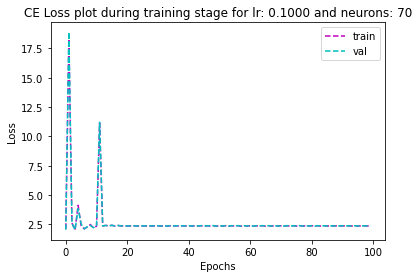

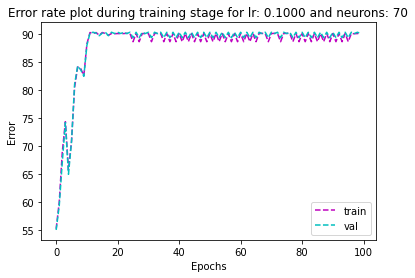

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.1000 and Hidden layer size: 70

Epoch:    0, Train Loss: 3.8324, Val Loss: 3.7710, Train Accuracy: 55.55%, Validation Accuracy: 55.67%
Epoch:   10, Train Loss: 2.4328, Val Loss: 2.7399, Train Accuracy: 27.83%, Validation Accuracy: 28.95%
Epoch:   20, Train Loss: 2.1626, Val Loss: 2.3539, Train Accuracy: 16.39%, Validation Accuracy: 17.32%
Epoch:   30, Train Loss: 3.0217, Val Loss: 3.7284, Train Accuracy: 16.79%, Validation Accuracy: 17.27%
Epoch:   40, Train Loss: 10.0194, Val Loss: 12.0485, Train Accuracy: 16.86%, Validation Accuracy: 17.55%
Epoch:   50, Train Loss: 2.0825, Val Loss: 2.5518, Train Accuracy: 17.47%, Validation Accuracy: 18.08%
Epoch:   60, Train Loss: 2.0583, Val Loss: 2.4701, Train Accuracy: 22.70%, Validation Accuracy: 23.10%
Epoch:   70, Train Loss: 2.0982, Val Loss: 2.7658, Train Accuracy: 21.26%, Validation Accuracy: 22.27%
Epoch:   80, Train 

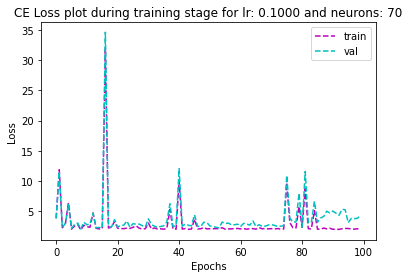

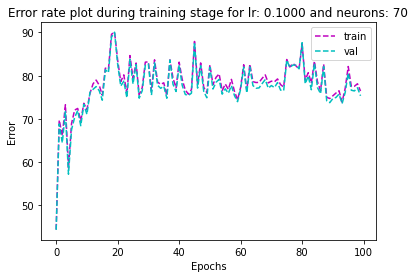

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.1000 and Hidden layer size: 70

Epoch:    0, Train Loss: 1.1618, Val Loss: 1.1239, Train Accuracy: 73.41%, Validation Accuracy: 73.26%
Epoch:   10, Train Loss: 2.3578, Val Loss: 2.3773, Train Accuracy: 19.86%, Validation Accuracy: 19.76%
Epoch:   20, Train Loss: 2.4470, Val Loss: 2.4678, Train Accuracy: 14.09%, Validation Accuracy: 13.23%
Epoch:   30, Train Loss: 2.2680, Val Loss: 2.2697, Train Accuracy: 16.41%, Validation Accuracy: 15.95%
Epoch:   40, Train Loss: 8.4564, Val Loss: 8.2888, Train Accuracy: 9.91%, Validation Accuracy: 9.68%
Epoch:   50, Train Loss: 2.3539, Val Loss: 2.3544, Train Accuracy: 9.87%, Validation Accuracy: 9.92%
Epoch:   60, Train Loss: 2.3564, Val Loss: 2.3566, Train Accuracy: 9.87%, Validation Accuracy: 9.92%
Epoch:   70, Train Loss: 2.3618, Val Loss: 2.3628, Train Accuracy: 11.36%, Validation Accuracy: 10.65%
Epoch:   80, Train Loss: 2.

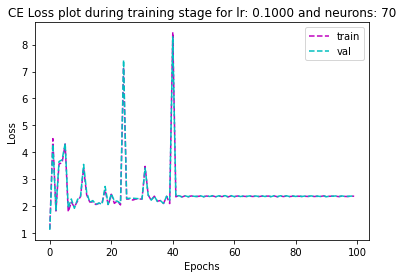

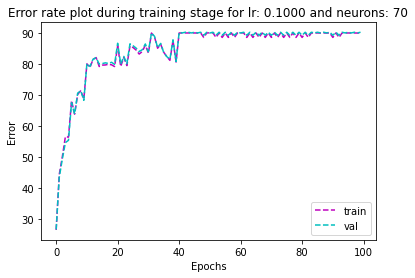

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.1000 and Hidden layer size: 70

Epoch:    0, Train Loss: 2.9308, Val Loss: 2.8039, Train Accuracy: 52.98%, Validation Accuracy: 54.09%
Epoch:   10, Train Loss: 2.3720, Val Loss: 2.4114, Train Accuracy: 23.09%, Validation Accuracy: 23.65%
Epoch:   20, Train Loss: 2.4475, Val Loss: 2.9478, Train Accuracy: 18.30%, Validation Accuracy: 18.91%
Epoch:   30, Train Loss: 2.1190, Val Loss: 2.2757, Train Accuracy: 20.10%, Validation Accuracy: 21.67%
Epoch:   40, Train Loss: 2.2339, Val Loss: 2.2190, Train Accuracy: 15.18%, Validation Accuracy: 16.07%
Epoch:   50, Train Loss: 9.3973, Val Loss: 10.7832, Train Accuracy: 12.85%, Validation Accuracy: 13.14%
Epoch:   60, Train Loss: 2.1785, Val Loss: 3.6110, Train Accuracy: 16.55%, Validation Accuracy: 16.66%
Epoch:   70, Train Loss: 2.2527, Val Loss: 3.9868, Train Accuracy: 14.87%, Validation Accuracy: 15.13%
Epoch:   80, Train L

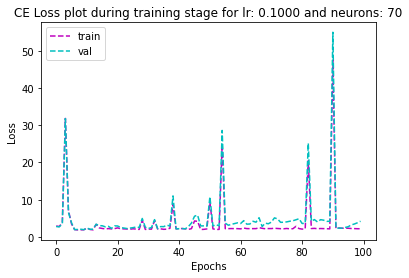

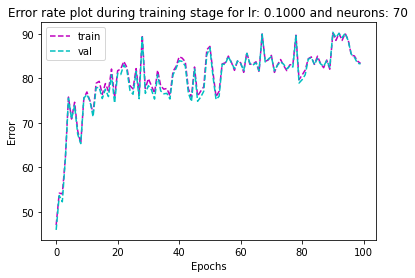

----------------------------------------------------------------------------------------
Running Experiment 1/5 with LR: 0.1000 and Hidden layer size: 100

Epoch:    0, Train Loss: 5.3292, Val Loss: 5.3665, Train Accuracy: 45.96%, Validation Accuracy: 45.14%
Epoch:   10, Train Loss: 2.4095, Val Loss: 2.3549, Train Accuracy: 16.40%, Validation Accuracy: 16.71%
Epoch:   20, Train Loss: 2.2910, Val Loss: 2.3528, Train Accuracy: 20.31%, Validation Accuracy: 19.55%
Epoch:   30, Train Loss: 2.3948, Val Loss: 2.3987, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   40, Train Loss: 2.3837, Val Loss: 2.3861, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   50, Train Loss: 2.3782, Val Loss: 2.3805, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   60, Train Loss: 2.3708, Val Loss: 2.3727, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   70, Train Loss: 2.3724, Val Loss: 2.3744, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   80, Train Loss: 2.374

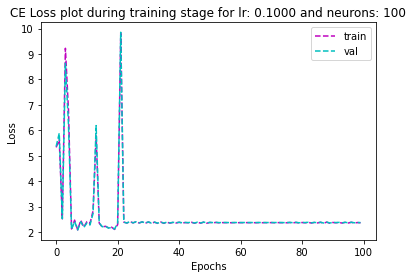

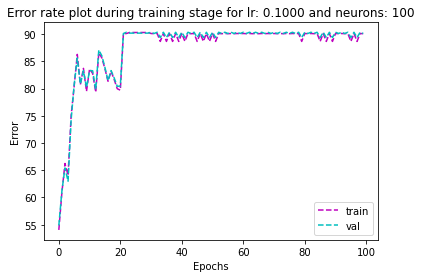

----------------------------------------------------------------------------------------
Running Experiment 2/5 with LR: 0.1000 and Hidden layer size: 100

Epoch:    0, Train Loss: 4.8543, Val Loss: 4.7851, Train Accuracy: 48.68%, Validation Accuracy: 48.43%
Epoch:   10, Train Loss: 2.2837, Val Loss: 2.2836, Train Accuracy: 16.04%, Validation Accuracy: 15.71%
Epoch:   20, Train Loss: 2.0701, Val Loss: 2.1120, Train Accuracy: 20.22%, Validation Accuracy: 19.79%
Epoch:   30, Train Loss: 2.1024, Val Loss: 2.1607, Train Accuracy: 19.34%, Validation Accuracy: 18.99%
Epoch:   40, Train Loss: 2.0640, Val Loss: 2.1151, Train Accuracy: 20.33%, Validation Accuracy: 19.80%
Epoch:   50, Train Loss: 2.0479, Val Loss: 2.1762, Train Accuracy: 20.41%, Validation Accuracy: 19.78%
Epoch:   60, Train Loss: 2.1672, Val Loss: 2.2351, Train Accuracy: 17.95%, Validation Accuracy: 17.57%
Epoch:   70, Train Loss: 2.1693, Val Loss: 2.2647, Train Accuracy: 18.52%, Validation Accuracy: 18.13%
Epoch:   80, Train L

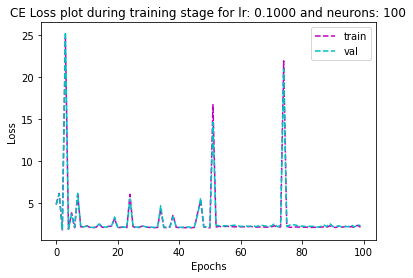

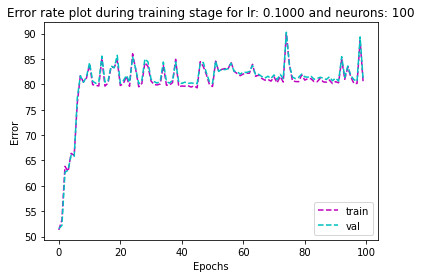

----------------------------------------------------------------------------------------
Running Experiment 3/5 with LR: 0.1000 and Hidden layer size: 100

Epoch:    0, Train Loss: 2.5656, Val Loss: 2.3944, Train Accuracy: 49.31%, Validation Accuracy: 50.58%
Epoch:   10, Train Loss: 1.9564, Val Loss: 1.9391, Train Accuracy: 26.52%, Validation Accuracy: 26.86%
Epoch:   20, Train Loss: 2.0660, Val Loss: 2.1021, Train Accuracy: 19.89%, Validation Accuracy: 19.44%
Epoch:   30, Train Loss: 2.4127, Val Loss: 2.4113, Train Accuracy: 9.72%, Validation Accuracy: 9.82%
Epoch:   40, Train Loss: 2.3634, Val Loss: 2.3645, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   50, Train Loss: 2.3608, Val Loss: 2.3615, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   60, Train Loss: 2.3616, Val Loss: 2.3630, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   70, Train Loss: 2.3676, Val Loss: 2.3690, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   80, Train Loss: 2.3

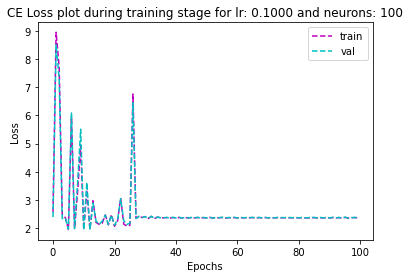

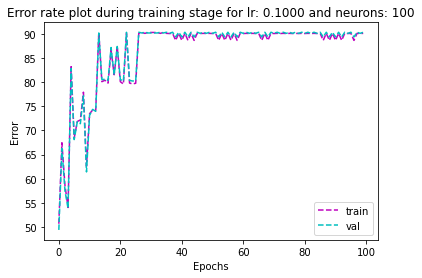

----------------------------------------------------------------------------------------
Running Experiment 4/5 with LR: 0.1000 and Hidden layer size: 100

Epoch:    0, Train Loss: 1.9072, Val Loss: 1.8373, Train Accuracy: 56.73%, Validation Accuracy: 57.64%
Epoch:   10, Train Loss: 3.3699, Val Loss: 3.3994, Train Accuracy: 17.62%, Validation Accuracy: 18.10%
Epoch:   20, Train Loss: 2.2386, Val Loss: 2.5691, Train Accuracy: 18.13%, Validation Accuracy: 18.88%
Epoch:   30, Train Loss: 13.1803, Val Loss: 14.5600, Train Accuracy: 9.95%, Validation Accuracy: 9.73%
Epoch:   40, Train Loss: 2.3722, Val Loss: 2.3745, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   50, Train Loss: 2.3930, Val Loss: 2.3959, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   60, Train Loss: 2.3787, Val Loss: 2.3812, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   70, Train Loss: 2.3786, Val Loss: 2.3806, Train Accuracy: 9.90%, Validation Accuracy: 9.67%
Epoch:   80, Train Loss: 2.3

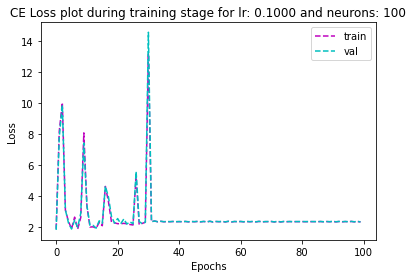

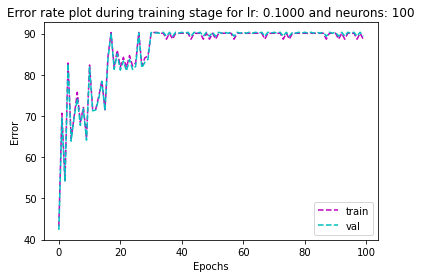

----------------------------------------------------------------------------------------
Running Experiment 5/5 with LR: 0.1000 and Hidden layer size: 100

Epoch:    0, Train Loss: 2.9197, Val Loss: 2.8707, Train Accuracy: 58.60%, Validation Accuracy: 59.08%
Epoch:   10, Train Loss: 2.1636, Val Loss: 2.1538, Train Accuracy: 17.82%, Validation Accuracy: 18.29%
Epoch:   20, Train Loss: 2.3598, Val Loss: 2.3609, Train Accuracy: 9.72%, Validation Accuracy: 9.82%
Epoch:   30, Train Loss: 2.3662, Val Loss: 2.3672, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   40, Train Loss: 2.3572, Val Loss: 2.3582, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   50, Train Loss: 2.3501, Val Loss: 2.3507, Train Accuracy: 11.36%, Validation Accuracy: 10.64%
Epoch:   60, Train Loss: 2.3613, Val Loss: 2.3622, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   70, Train Loss: 2.3582, Val Loss: 2.3592, Train Accuracy: 9.94%, Validation Accuracy: 9.90%
Epoch:   80, Train Loss: 2.3

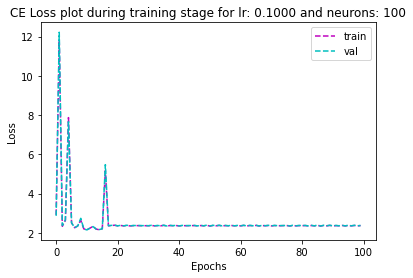

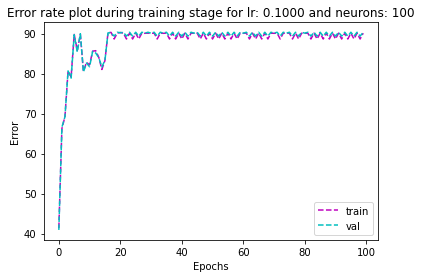

--------------------------------------------------------------------

Best Neuron size: 100, Best LR: 0.0010 with best Val Accuracy:97.96%

--------------------------------------------------------------------


In [58]:
batch_size  = 1000 
num_epochs = 100   # Total number of epochs  
num_batches = math.ceil(len(train_images)/batch_size)
num_runs = 5 # To peform random initialization for each setting
lr_rates = [0.001, 0.01, 0.1] # possible learning rates
neurons = range(10, 110, 30) # possible hidden layer sizes with step size 30

print("----------------------------------------------------------------------------------------")
print("Training Setting as below: ")
print("Num of runs: {}".format(num_runs))
print("Batch Size: {}".format(batch_size))
print("No of epochs: {}".format(num_epochs))
print("No of Batches per epoch: {}".format(num_batches))
print("----------------------------------------------------------------------------------------\n\n")


num_exp = 0
best_val_acc = 0.00


# Main loop to find the optimal configuration
for lr in lr_rates:
    for neuron in neurons:
        for run in range(num_runs):
            print("----------------------------------------------------------------------------------------")
            print("Running Experiment {}/{} with LR: {:.4f} and Hidden layer size: {}\n"\
                  .format(run+1, num_runs, lr, neuron))
            val_acc, test_acc, trained_net, *loss_curves = training(neuron, lr, num_epochs, batch_size, num_batches)
            num_exp +=1
                        
            # pick the model with best accuracy on validation data
            if best_val_acc < val_acc:
                best_neuron = neuron
                best_lr = lr
                best_val_acc = val_acc
                best_test_acc = test_acc
                best_loss_curves = loss_curves
                # save  the best model to disk
                torch.save( trained_net, "best_net.pth")


# Print the optimal configuration
print("--------------------------------------------------------------------\n")
print("Best Neuron size: {}, Best LR: {:.4f} with best Val Accuracy:{:.2f}%\n"\
      .format(best_neuron, best_lr, 100*best_val_acc))
print("--------------------------------------------------------------------")

        

In [59]:
# Print the optimal configuration again!

print("-------------------------------------------------------------------------------\n")
print("Optimal Neuron size: {}, Optimal LR: {:.4f} with highest Val Accuracy: {:.2f}%\n"\
      .format(best_neuron, best_lr, 100*best_val_acc))
print("---------------------------------------------------------------------------------")

-------------------------------------------------------------------------------

Optimal Neuron size: 100, Optimal LR: 0.0010 with highest Val Accuracy: 97.96%

---------------------------------------------------------------------------------


In [60]:
# Load the optimal model 
net = torch.load('./best_net.pth')
loss_fn = nn.CrossEntropyLoss()
predictions_test, loss_test_ = predict(net, test_images, test_labels, loss_fn)
accuracy_test = accuracy(predictions_test, test_labels)

print("------------------------------------------------------------------------------------\n")
print("\nFinal Test accuracy for optimal Network with hidden layer of {} neurons and LR: {:.4f} is {:.2f}%\n\n"\
      .format(best_neuron, best_lr, accuracy_test*100))
print("----------------------------------------------------------------------------------------")


------------------------------------------------------------------------------------


Final Test accuracy for optimal Network with hidden layer of 100 neurons and LR: 0.0010 is 97.77%


----------------------------------------------------------------------------------------


## Final Submissions ##


### 1. Access to your GitHub so that we can inspect your code

- We will present the results in the final report along with other questions.   


### 2. Plot showing the accuracy and loss on the training and the validation set with respect to the training epochs. ###

- We run the MLP network for 100 epochs with Adam optimizer using possible hyperparameters  as below:

    a. Learning rates  :  [0.001, 0.01, 0.1] 

    b. Number of neurons in hidden layers: [10, 40, 70, 100]

    c. Different initializations: 5 times


   #### Basing on running all possible configurations, we found the  accuracy of 97.77% on test data with lr=0.001 and neurons=100. The hyperparameters were selected using validation.

We present the plot for this setting on both training and validations set below.



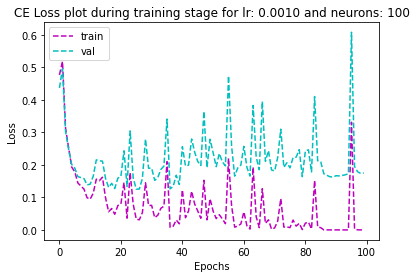

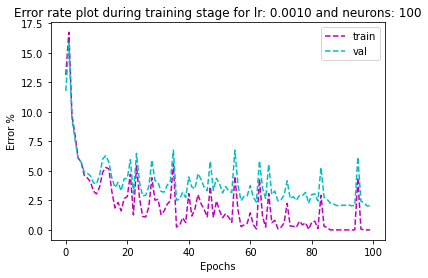

In [69]:

plt.title('CE Loss plot during training stage for lr: {:.4f} and neurons: {}'.format(best_lr, best_neuron))
plt.plot( np.arange(num_epochs), best_loss_curves[0][0], color = "m", linestyle = "--")
plt.plot( np.arange(num_epochs), best_loss_curves[0][1], color = "c", linestyle = "--")
plt.legend(['train', 'val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.title('Error rate plot during training stage for lr: {:.4f} and neurons: {}'.format(best_lr, best_neuron))
plt.plot( np.arange(num_epochs), best_loss_curves[0][2], color = "m", linestyle = "--")
plt.plot( np.arange(num_epochs), best_loss_curves[0][3], color = "c", linestyle = "--")
plt.legend(['train', 'val'])
plt.xlabel('Epochs')
plt.ylabel('Error %')
plt.show()

    

We observe from above plots, the error rate decreases with epochs although there is certain unstability.